# Metodología {-}

Este notebook es el principal del proyecto. En él se tiene: la carga de las distintas fuentes de datos, su EDA, su preprocesamiento, el feature engineering y la selección de variables. Además, se ha añadido un apartado con modelos de prueba que promovieron la creación de las variables logarítmicas de year_to_year_change, price_compare_london, etc.

In [1]:
import pandas as pd
import numpy as np
import random

import os
import glob
import pickle

import geopandas as gpd

import joblib

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor


In [2]:
def load_vars(name_list=None, folder="../data/Por fecha/"):
    # https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe
    # https://stackoverflow.com/questions/26063231/read-specific-columns-with-pandas-or-other-python-module
    all_files = glob.glob(os.path.join(folder, "*.csv"))
    return pd.concat((pd.read_csv(f, usecols=name_list) for f in all_files), ignore_index=True)

# Data collection

## Datos de Kaggle

In [3]:
# https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe

# Train data set
path = "../data/train/"
all_files = glob.glob(os.path.join(path, "*.csv"))
train_df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

# Test data set
path = "../data/test/"
all_files = glob.glob(os.path.join(path, "*.csv"))
test_df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

train_df.head(1)

,Unnamed: 0,Transaction.unique.identifier,Price,Date.of.Transfer,Postcode,Property.Type,Old.New,Duration,PAON,SAON,Street,Locality,Town.City,District,County,PPD.Category.Type,Record.Status...monthly.file.only
0,0,{677AA6E5-A626-461A-BE2B-7B0580842D46},300000,1995-01-01 00:00,SW19 5JU,Piso/Apartamento,Nuevo,Alquiler,1,FLAT 6,SOMERSET ROAD,LONDON,LONDON,MERTON,GREATER LONDON,A,A


### Preparación de los datos

Modificamos la variable Date para que represente la fecha en un formato legible. Además, vamos a convertir todo el texto a minúsculas y a corregir el nombre de una de las entradas de los distritos:

In [4]:
def prepare_data(df):
    # Date.of.Transfer to year, month and day
    df["Date.of.Transfer"] = pd.to_datetime(df["Date.of.Transfer"])
    df["Year"] = df["Date.of.Transfer"].dt.year
    df["month"] = df["Date.of.Transfer"].dt.month
    df["day"] = df["Date.of.Transfer"].dt.day

    # Lower case
    to_lower_cols = ("PAON","SAON","Street","Locality",
                     "Town.City","District","County")
    for col in to_lower_cols:
        df.loc[:, col] = df.loc[:, col].str.lower()

    # Correct district name
    # In the data exists the wrekin and wrekin separatedly
    # Maybe b/c they are different region over time
    df.loc[:, "District"] = df.loc[:, "District"].replace(to_replace="the wrekin", 
                                                          value="wrekin")
prepare_data(train_df)
prepare_data(test_df)


train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2601998 entries, 0 to 2601997
Data columns (total 20 columns):
 #   Column                             Dtype         
---  ------                             -----         
 0   Unnamed: 0                         int64         
 1   Transaction.unique.identifier      object        
 2   Price                              int64         
 3   Date.of.Transfer                   datetime64[ns]
 4   Postcode                           object        
 5   Property.Type                      object        
 6   Old.New                            object        
 7   Duration                           object        
 8   PAON                               object        
 9   SAON                               object        
 10  Street                             object        
 11  Locality                           object        
 12  Town.City                          object        
 13  District                           object        
 14  Co

## Datos censales

Con ejecutarlo una vez basta, así que se ha comentado.

In [5]:
# # Load all files
# folder = "../_00_Informacion/census/"
# glob.glob(os.path.join(folder, "*.csv"))

# # Initialize census_df with the first one (Total Population)
# census_df = pd.read_csv('../_00_Informacion/census\\age_sex_population_uk.csv', comment="#") 

# census_df.columns = ["District", "total_people", "%"]
# census_df = census_df.loc[:, ["District", "total_people"]]
# census_df["District"] = census_df["District"].str.lower()

# # Add amount of people working and studying
# temp = pd.read_csv('../_00_Informacion/census\\employment_data_uk.csv', comment="#") 

# temp = temp.iloc[:, [0,1,4]]
# temp.columns = ["District", "people_working", "people_studying"]
# temp["District"] = temp["District"].str.lower()

# census_df = pd.merge(left=census_df, right=temp, how="outer", on="District")

# # Add number of houses and their proportion in each energy band
# temp = pd.read_csv('../_00_Informacion/census\\energy_efficiency_uk.csv', comment="#") 

# temp = temp.iloc[:, np.append(np.append(np.array(0), np.arange(3,16,2)), np.array(16))]
# temp.columns = ["total_houses", "BandA", "BandB", 
#                 "BandC", "BandD", "BandE", 
#                 "BandF", "BandG", "District"]
# temp["District"] = temp["District"].str.lower()

# census_df = pd.merge(left=census_df, right=test_df, how="outer", on="District")

# # Add job_density
# temp = pd.read_csv('../_00_Informacion/census\\job_density_uk.csv', comment="#") 

# temp.columns = ["District", "job_density"]
# temp["District"] = temp["District"].str.lower()

# census_df = pd.merge(left=census_df, right=temp, how="outer", on="District")

# # Add population density (per hectare)
# temp = pd.read_csv('../_00_Informacion/census\\population_data_uk.csv', comment="#") 

# temp = temp.iloc[:, [0,-1]]
# temp.columns = ["District", "density_population_hectare"]
# temp["District"] = temp["District"].str.lower()

# census_df = pd.merge(left=census_df, right=temp, how="outer", on="District")

# # Correct data (object to number)
# census_df["people_studying"] = pd.to_numeric(census_df.loc[:, "people_working"], errors="coerce")
# census_df["people_working"] = pd.to_numeric(census_df.loc[:, "people_working"], errors="coerce")

# # District name correction
# corrections = [("county durham", "durham"),
#                ("westminster", "city of westminster"),
#                ("herefordshire, county of", "herefordshire"),
#                ("kingston upon hull, city of", "kingston upon hull"),
#                ("st. helens", "st helens"),
#                ("telford and wrekin", "wrekin"),
#                ("bristol, city of", "bristol"),
#                ("folkestone and hythe", "shepway")]

# for current, correct in corrections:
#     census_df.replace(to_replace=current, value=correct, inplace=True)

# # Save results
# with open('../output/census_df.pkl', 'wb') as f:
#             pickle.dump(census_df, f)

# Load census data
with open('../output/census_df.pkl', 'rb') as f:
            census_df = pickle.load(f)

census_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362 entries, 0 to 361
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   District                    362 non-null    object 
 1   total_people                319 non-null    float64
 2   people_working              330 non-null    float64
 3   people_studying             330 non-null    float64
 4   total_houses                331 non-null    float64
 5   BandA                       331 non-null    float64
 6   BandB                       331 non-null    float64
 7   BandC                       331 non-null    float64
 8   BandD                       331 non-null    float64
 9   BandE                       331 non-null    float64
 10  BandF                       331 non-null    float64
 11  BandG                       331 non-null    float64
 12  job_density                 332 non-null    float64
 13  density_population_hectare  348 non

## Datos geográficos

### Mapa de Reino Unido

In [6]:
# Load the UK regions shapefile
uk_geo = gpd.read_file('../_00_Informacion/UK shapefile/gadm41_GBR_3.shp')
uk_geo = uk_geo.set_crs(4326) # set Coordinates Reference System (long, lat)
uk_geo = uk_geo.loc[:, ["NAME_3", "geometry"]]

# Change district names (NAME_3) to match previous data
uk_geo.loc[:, "NAME_3"] = uk_geo.loc[:, "NAME_3"].str.lower()
uk_geo.loc[90, "NAME_3"] = "southwark" # it was NA
uk_geo.loc[54, "NAME_3"] = "castle point" # it was NA

corrections = [("saint helens", "st helens"),
               ("saint edmundsbury", "st edmundsbury"),
               ("saint albans", "st albans"),
               ("rhondda, cynon, taff", "rhondda cynon taff"),
               ("telford and wrekin", "wrekin")]

for current, correct in corrections:
    uk_geo.replace(to_replace=current, value=correct, inplace=True)

uk_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   NAME_3    406 non-null    object  
 1   geometry  406 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 6.5+ KB


### Posición de los pueblos y ciudades del dataset de Kaggle

In [7]:
# Check Coordenadas_API.ipynb
with open('../output/town_city_coords.pkl', 'rb') as f:
    town_city_coords = pickle.load(f)

town_city_coords.rename(columns={"Town/City": "Town.City"}, inplace=True)
town_city_coords["geometry"] = gpd.points_from_xy(town_city_coords.Longitude, 
                                                  town_city_coords.Latitude, 
                                                  crs=4326) # Latitude / Longitude
town_city_coords = gpd.GeoDataFrame(town_city_coords) 
town_city_coords.geometry = town_city_coords.geometry.to_crs(uk_geo.crs)
town_city_coords.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 7563 entries, 0 to 7562
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   address    7563 non-null   object  
 1   Latitude   7563 non-null   float64 
 2   Longitude  7563 non-null   float64 
 3   Town.City  7563 non-null   object  
 4   District   7563 non-null   object  
 5   County     7563 non-null   object  
 6   geometry   7563 non-null   geometry
dtypes: float64(2), geometry(1), object(4)
memory usage: 472.7+ KB


# EDA (Exploratory Data Analysis)

Empecemos viendo una muestra de los datos:

In [8]:
pd.read_csv("..\\data\\Por fecha\\UK_Property_Price_Data_1995.csv", 
                       header=0, sep=',', nrows=10).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Transaction unique identifier      10 non-null     object
 1   Price                              10 non-null     int64 
 2   Date of Transfer                   10 non-null     object
 3   Postcode                           10 non-null     object
 4   Property Type                      10 non-null     object
 5   Old/New                            10 non-null     object
 6   Duration                           10 non-null     object
 7   PAON                               10 non-null     object
 8   SAON                               2 non-null      object
 9   Street                             10 non-null     object
 10  Locality                           10 non-null     object
 11  Town/City                          10 non-null     object
 12  District   

La mayoría son "object", pero podemos ver un resumen estadístico de Price:

In [9]:
price = load_vars(["Price"])
price.describe()

,Price
count,2.827623e+07
mean,2.181305e+05
std,8.688524e+05
min,1.000000e+00
25%,8.495000e+04
50%,1.499500e+05
75%,2.475000e+05
max,5.943000e+08


In [10]:
# Sample
price = pd.DataFrame(random.sample(list(price["Price"]), 
                                   k=int(price.shape[0]*0.1)))
price.columns = ["Price"]
price.describe()

,Price
count,2.827622e+06
mean,2.173681e+05
std,7.406002e+05
min,1.000000e+00
25%,8.495000e+04
50%,1.499500e+05
75%,2.475000e+05
max,3.251691e+08


La muestra tiene aproximadamente las mismas propiedades que los datos completos:

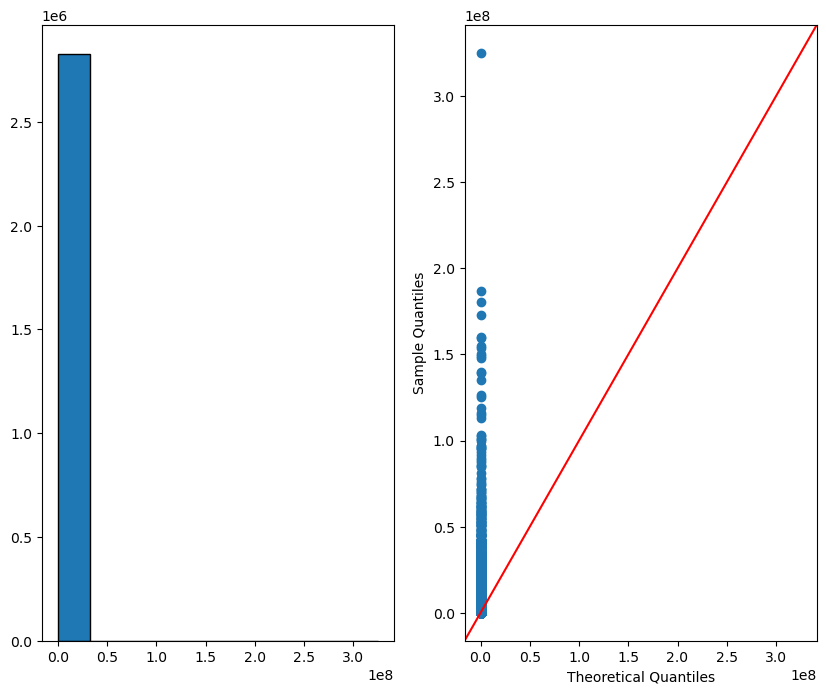

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 8))

ax[0].hist(price, edgecolor='black')

import statsmodels.api as sm
sm.qqplot(price, line="45", ax=ax[1])

plt.show()

Está muy sesgado a la izquierda y, evidentemente, no sigue la distribución normal.

In [12]:
train_df["date2"] = train_df["Date.of.Transfer"].dt.strftime("%Y-%m")
test_df["date2"] = test_df["Date.of.Transfer"].dt.strftime("%Y-%m")
# pd.to_datetime(train_df[["Year", "month", "day"]]).dt.strftime("%Y-%m")


## Evolución del precio

In [13]:
temp = pd.concat(
    [train_df.loc[:, ("date2", "Property.Type", "Duration", 
                        "Old.New", "PPD.Category.Type",
                        "Price")].copy(),
     test_df.loc[:, ("date2", "Property.Type", "Duration", 
                        "Old.New", "PPD.Category.Type",
                        "Price")].copy()],
    axis = 0
)

temp["date2"] = pd.to_datetime(temp["date2"])
temp.to_csv("../output/R/evolucion.csv")
# temp
del temp

In [14]:
# from scipy import stats
# from plotnine import *
# import patchworklib as pw
# from mizani.breaks import date_breaks

In [15]:
# temp_ini = train_df.loc[:, ("date2", 'Property.Type', 'Price')].copy()
# temp_ini["date2"] = pd.to_datetime(temp_ini["date2"])

# # Group by date, calculate mean and standard error, and then the confidence intervals
# summary_data = (
#     temp_ini.groupby(['date2', 'Property.Type'])['Price']
#     .agg(mean_price='mean', std_dev='std', n='count')
#     .reset_index()
# )

# # Calculate 95% confidence interval
# confidence_level = 0.95
# summary_data['ci'] = stats.t.ppf((1 + confidence_level) / 2, summary_data['n'] - 1) * (summary_data['std_dev'] / summary_data['n']**0.5)
# summary_data['lower'] = summary_data['mean_price'] - summary_data['ci']
# summary_data['upper'] = summary_data['mean_price'] + summary_data['ci']

# summary_data.columns = ("date2", "Tipo", "Price", "std", "n", "ci", "lower", "upper")
# display(summary_data)

# g1 = (
#     ggplot(summary_data, aes(x='date2', y='Price', color='Tipo'))
#     + geom_line()
#     + geom_ribbon(mapping=aes(x="date2", ymin="lower", ymax="upper", fill="Tipo"), 
#                   alpha=0.5, linetype="") 
    
#     # Styling
#     + scale_y_log10()
#     + scale_x_datetime(breaks=date_breaks('5 years'), date_labels="%Y")
#     # + scale_color_discrete(guide=False)
# )

In [16]:
# temp_ini = train_df.loc[train_df["Property.Type"] != "Otro", :].loc[:, ("date2", 'Property.Type', 'Price')].copy()
# temp_ini["date2"] = pd.to_datetime(temp_ini["date2"])

# # Group by date, calculate mean and standard error, and then the confidence intervals
# summary_data = (
#     temp_ini.groupby(['date2', 'Property.Type'])['Price']
#     .agg(mean_price='mean', std_dev='std', n='count')
#     .reset_index()
# )

# # Calculate 95% confidence interval
# confidence_level = 0.95
# summary_data['ci'] = stats.t.ppf((1 + confidence_level) / 2, summary_data['n'] - 1) * (summary_data['std_dev'] / summary_data['n']**0.5)
# summary_data['lower'] = summary_data['mean_price'] - summary_data['ci']
# summary_data['upper'] = summary_data['mean_price'] + summary_data['ci']

# summary_data.columns = ("date2", "Tipo", "Price", "std", "n", "ci", "lower", "upper")
# display(summary_data)

# map_properties = {"Adosado": 'green', "Semi-adosado": 'lime', "Unifamiliar": 'blue', 
#                           "Piso/Apartamento": 'red', "Otro": 'purple'}

# g2 = (
#     ggplot(summary_data, aes(x='date2', y='Price', color='Tipo'))
#     + geom_line()
#     + geom_ribbon(mapping=aes(x="date2", ymin="lower", ymax="upper", fill="Tipo"), 
#                   alpha=0.5, linetype="") 
    
#     # Styling
#     + scale_x_datetime(breaks=date_breaks('5 years'), date_labels="%Y")

#     # Legend
#     + scale_color_manual(values=map_properties)
# )

In [17]:
# # Render the plot and retrieve its legend
# fig = g1.draw()  # This renders the plot as a matplotlib figure

# # Extract the legend handles and labels
# legend = fig.legend  # Get the legend from the plot (if multiple, select as needed)
# legend_fig = plt.figure()  # Create a new figure for the legend

In [18]:
# import matplotlib.pyplot as plt
# import plotly.graph_objects as go  # For combining plots if needed
# import plotly.subplots as sp

# # Render the plot and retrieve its legend
# fig = g1.draw()  # This renders the plot as a matplotlib figure

# # Extract the legend
# legend = fig.legends[0]  # Get the legend from the plot (if multiple, select as needed)

# # Create a new figure for just the legend
# legend_fig = plt.figure(figsize=(2, 3))  # Adjust size as needed
# legend_ax = legend_fig.add_subplot(111)  # Add a subplot to hold the legend

# # Draw only the legend on this figure
# legend_ax.legend(handles=legend.legendHandles, labels=[text.get_text() for text in legend.get_texts()],
#                  loc='center', frameon=False)
# legend_ax.axis('off')  # Hide axes

# # Display the legend-only figure
# plt.show()

# # Alternatively, if you wish to display the legend alongside other plots:
# # Render `g1` and `g2` with plotly
# g1_pw = pw.load_ggplot(g1, figsize=(2, 3))
# g2_pw = pw.load_ggplot(g2, figsize=(2, 3))

# # Note: For combining, you would need a combined figure function, like using Plotly's subplots


In [19]:
# # Render the plot and retrieve its legend
# fig = g1.draw()  # This renders the plot as a matplotlib figure

# # Extract the legend handles and labels
# legend = fig.legend  # Get the legend from the plot (if multiple, select as needed)
# legend_fig = plt.figure()  # Create a new figure for the legend

# # Add the legend to the new figure
# legend_fig.legend(handles=legend, labels=[t.get_text() for t in legend.get_texts()], loc='center')
# legend_fig.canvas.draw()  # Draw the legend figure

# # Adjust and show
# legend_fig.subplots_adjust(left=0.3, right=0.7, top=0.7, bottom=0.3)  # Center the legend
# plt.show()


# g1_pw = pw.load_ggplot(g1, figsize=(2,3))
# g2_pw = pw.load_ggplot(g2, figsize=(2,3))
# legend = pw.load_ggplor(legend, figsize=(2,3))
# g1_pw|g2_pw


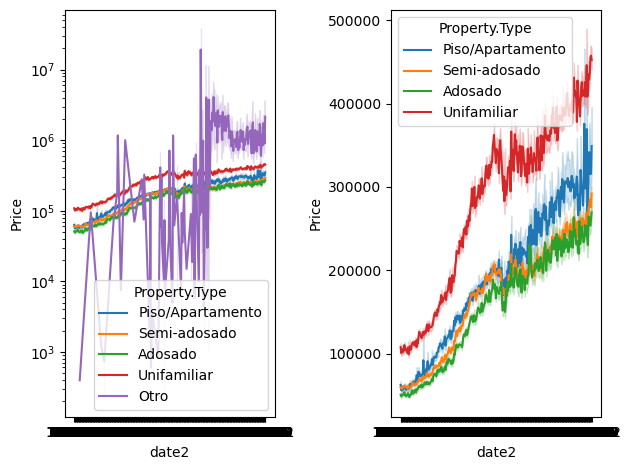

In [20]:
fig, ax = plt.subplots(ncols=2)

sns.lineplot(train_df, 
             x="date2", y="Price", hue="Property.Type",
             ax=ax[0])
ax[0].set_yscale("log")

sns.lineplot(train_df.loc[train_df["Property.Type"] != "Otro", :], 
             x="date2", y="Price", hue="Property.Type",
             ax=ax[1])
ax[1].set_yscale("linear")

plt.tight_layout()
plt.show()

Las propiedades de categoría "Otro" introducen un error innecesario.

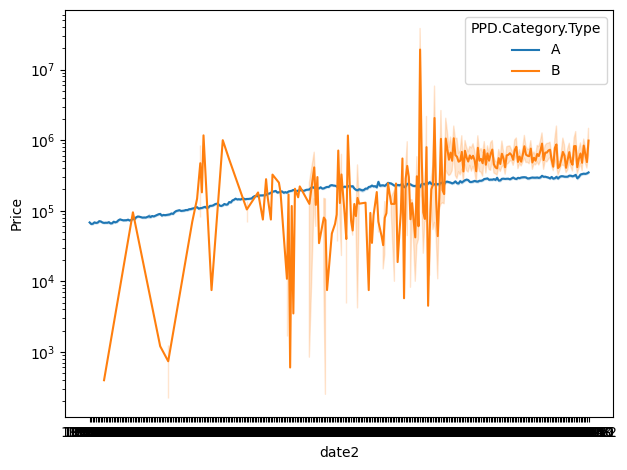

In [21]:
fig, ax = plt.subplots(ncols=1)

sns.lineplot(train_df, 
             x="date2", y="Price", hue="PPD.Category.Type",
             ax=ax)
ax.set_yscale("log")

plt.tight_layout()
plt.show()

Sigue la forma de la curva de precios de las propiedades de categoría "Otro".

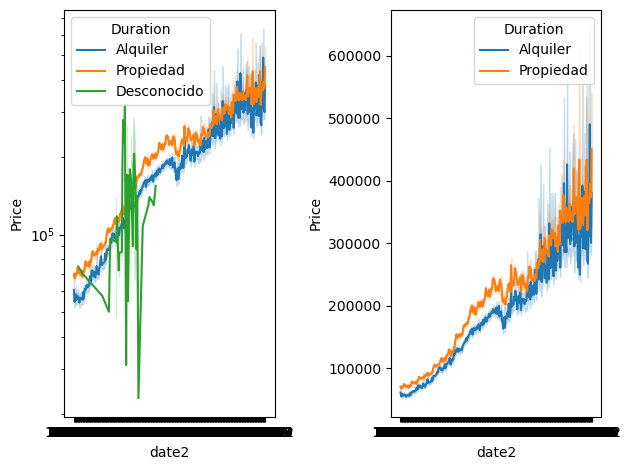

In [22]:
fig, ax = plt.subplots(ncols=2)

sns.lineplot(train_df, 
             x="date2", y="Price", hue="Duration",
             ax=ax[0])
ax[0].set_yscale("log")

sns.lineplot(train_df.loc[train_df["Duration"] != "Desconocido", :], 
             x="date2", y="Price", hue="Duration",
             ax=ax[1])
ax[1].set_yscale("linear")

plt.tight_layout()
plt.show()

Las propiedades con teniencia desconocida no solo introducen un ruido significativo, sino que, además, no abarca todas las fechas.

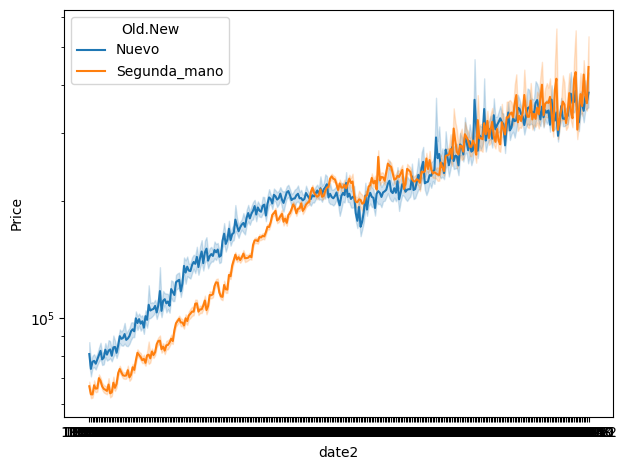

In [23]:
fig, ax = plt.subplots(ncols=1)

sns.lineplot(train_df, 
             x="date2", y="Price", hue="Old.New",
             ax=ax)
ax.set_yscale("log")

plt.tight_layout()
plt.show()

### PPD Category Type
Se destacan en la información varias cosas:
+ Solo se registran casos de ventas "B" (precio adicional) a partir de 2013.
+ Todos los casos de "O" (Otro) en Property Type entran en la categoría B.

<img src="../output/images/PPD1.jpeg" width="500">

## Categorías únicas por variable

Con ejecutarlo una vez basta, así que se ha comentado.

In [24]:
# # Get vocabulary (~4 minutes)
# columnas = pd.read_csv("..\\data\\Por fecha\\UK_Property_Price_Data_1995.csv", 
#                        header=0, sep=',', nrows=1).select_dtypes("object").columns

# data_geo = dict()
# for col in columnas:
#     data_geo[col] = load_vars([col]).loc[:, col].dropna().str.lower().unique()
#     print(f"\r{col} done!", end="")
# print("\r", end="")

# # Save results
# with open('../output/data_geo.pkl', 'wb') as f:
#             pickle.dump(data_geo, f)

with open('../output/data_geo.pkl', 'rb') as f:
            data_geo = pickle.load(f)

# Show results
print("--- Número de categorías únicas ---\n")
for key,value in data_geo.items():
    print(f"{key}: {len(value)}")

--- Número de categorías únicas ---

Transaction unique identifier: 28276228
Date of Transfer: 10338
Postcode: 1296549
Property Type: 5
Old/New: 2
Duration: 3
Street: 326400
Locality: 23862
Town/City: 1172
District: 467
County: 132
PPD Category Type: 2
Record Status - monthly file only: 1


En primer lugar, los casos más llamativos:

In [25]:
# Drop unusable columns
train_df.drop(labels=["Unnamed: 0", "Transaction.unique.identifier", "Record.Status...monthly.file.only"], 
              inplace=True, axis=1)
test_df.drop(labels=["Unnamed: 0", "Transaction.unique.identifier", "Record.Status...monthly.file.only"], 
              inplace=True, axis=1)

Podemos ver que la cardinalidad aumenta rápidamente para las variables espaciales conforme profundizamos más en la posición de la casa. Además, hay que tener en cuenta que algunos lugares tienen nombres repetidos en otros sitios. Por ejemplo, es muy probable que muchos nombres de calles se repitan en varios pueblos y ciudades.

Vamos a limitar nuestra granularidad al rango "District" e incluso "Town/City" en las aplicaciones que se permita. Veamos también el número de pueblos y ciudades que tenemos en realidad teniendo en cuenta que se pueden repetir los nombres de algunos por distrito:

In [26]:
# Number of district-town/city cases
temp = load_vars(["County", "District", "Town/City"])

hierarchy_geo = temp.groupby(["County", "District"]).agg(lambda x: len(set(x))).reset_index()
print(f"Número real de Pueblos y Ciudades: {hierarchy_geo['Town/City'].sum()}")
del temp

Número real de Pueblos y Ciudades: 7563


Vamos a pasar al notebook "Coordendas_API.ipynb" para extraer las coordenadas de cada pueblo o ciudad. Se guarda el resultado en un archivo .pkl.

## Casos duplicados 

Como contamos con un identificador unívoco de la transacción, en principio podemos detectar duplicados usando únicamente esa variable. no obstante, dicho identificador se usa únicamente en este dataset, por lo que, si la fuente original tuvo errores de guardado, no sería efectivo este método.

In [27]:
temp = load_vars(["Transaction unique identifier"])
print(f"Número de casos duplicados (según ID): {temp.duplicated().sum()}")
del temp

Número de casos duplicados (según ID): 0


## Datos faltantes

### Datos de Kaggle

<img src="../output/images/NAs.jpeg" width="500">

### Datos censales

En este conjunto de datos, los NAs vienen de las uniones que hemos hecho. Por ejemplo, aunque la variable "density_population_hectare" puede tomar valores para el distrito "X", esto no tiene por qué ser así para job_density.

In [28]:
census_df

,District,total_people,people_working,people_studying,total_houses,BandA,BandB,BandC,BandD,BandE,BandF,BandG,job_density,density_population_hectare
0,hartlepool,95400.0,41200.0,41200.0,25868.0,0.3,11.8,32.3,41.0,12.3,1.9,0.5,0.60,9.8
1,middlesbrough,152700.0,60400.0,60400.0,39510.0,0.2,12.8,32.2,40.5,12.4,1.4,0.4,0.79,25.7
2,redcar and cleveland,137900.0,64500.0,64500.0,32677.0,0.2,12.2,28.4,41.3,14.8,2.5,0.7,0.55,5.5
3,stockton-on-tees,202400.0,90400.0,90400.0,48149.0,0.2,12.7,33.4,41.2,10.8,1.3,0.3,0.78,9.4
4,darlington,110600.0,55000.0,55000.0,28777.0,0.3,14.2,28.9,38.8,14.9,2.3,0.6,0.87,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,purbeck,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1
358,west dorset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9
359,weymouth and portland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.6
360,taunton deane,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.4


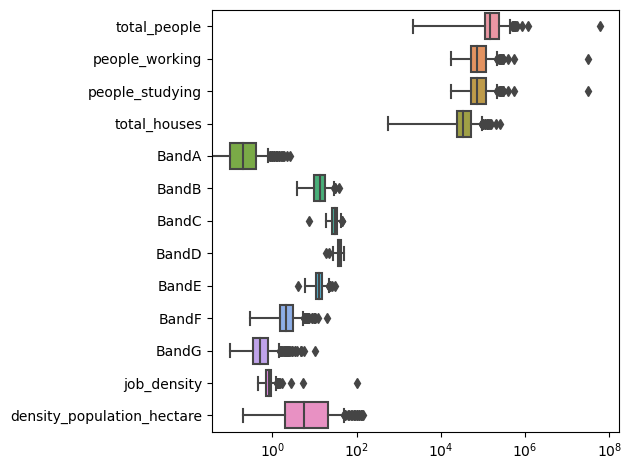

In [29]:
fig, ax = plt.subplots()
sns.boxplot(data=census_df, ax=ax, orient="h")
# plt.xticks(rotation=90)


plt.xscale("log")
plt.tight_layout()
plt.show()

Vamos a imputar los valores perdidos por la media de los valores. Esto será especialmente válido para las variables con poca dispersión relativa, pero, como vemos en las primeras variables, esto no siempre es el caso. No obstante, lo haremos así hasta pensar en una solución mejor y factible:

In [30]:
census_numeric_columns = census_df.select_dtypes(include=['number']).columns
census_df[census_numeric_columns] = census_df[census_numeric_columns].fillna(census_df[census_numeric_columns].mean())

## Eliminación de casos minoritarios que introducen ruido

In [31]:
def delete_cases(df):
    mask = (df["Property.Type"] != "Otro") &\
        (df["Duration"] != "Desconocido") &\
        (df["PPD.Category.Type"] != "B")
    
    return df.loc[mask, :]

train_df = delete_cases(train_df)
test_df = delete_cases(test_df)

## Outliers

### Nuevas variables: q1 y q3

Vamos a añadir nuevas variables referentes a los outliers por año y distrito. Primero calcularemos los cuartiles primero y tercero y, a partir de estos, inferiremos el rango intercuartílico. Después, especificaremos para cada caso si el valor de la venta es outlier por encima de los precios esperados o por debajo.

In [32]:
by_district = False

In [33]:
# https://stackoverflow.com/questions/48994157/get-the-number-of-outliers-by-group-in-pandas

if by_district:
    def get_q1_q3(df):
        """
        Used as an auxiliary function of 'get_outliers'.
        Create new columns with the values of the first quartile (q1) and the third one (q3).
        Also adds the IQR to ease the calculation of the following variables.
        """
        temp = df.loc[:, ["Price", "Year", "month", "District"]].groupby(["District", "Year", "month"]).agg(
            q1=("Price", lambda x: np.percentile(x, 25)),
            q3=("Price", lambda x: np.percentile(x, 75))
        ).reset_index()
        
        temp["IQR"] = temp["q3"] - temp["q1"]
        
        return pd.merge(left=df, right=temp, how="left", on=("District", "Year", "month"))

else:
    def get_q1_q3(df):
        """
        Used as an auxiliary function of 'get_outliers'.
        Create new columns with the values of the first quartile (q1) and the third one (q3).
        Also adds the IQR to ease the calculation of the following variables.
        """
        temp = df.loc[:, ["Price", "Year", "month", "day"]].\
            groupby(["Year", "month", "day"]).agg(
                q1=("Price", lambda x: np.percentile(x, 25)),
                q3=("Price", lambda x: np.percentile(x, 75))
            ).reset_index()
        
        temp["IQR"] = temp["q3"] - temp["q1"]
        
        return pd.merge(left=df, right=temp, how="left", on=("Year", "month", "day"))


def get_outliers(df):
    """
    Creates the new variables from 'get_q1_q3' and another two, which indicate if the price value
    is above the expected value for that district on the specified time or below.
    """
    temp = df.copy()
    temp = get_q1_q3(temp)
    temp.loc[:, "is_top_outlier"] = (temp["Price"] > (temp["q3"] + 1.5 * temp["IQR"])).astype("int")
    temp.loc[:, "is_bottom_outlier"] = (temp["Price"] < (temp["q1"] - 1.5 * temp["IQR"])).astype("int")
    temp.drop(["IQR"], axis=1, inplace=True) # b/c is linear combination of q1 and q3
    return temp

train_df = get_outliers(train_df)
train_df.head(3)

,Price,Date.of.Transfer,Postcode,Property.Type,Old.New,Duration,PAON,SAON,Street,Locality,...,County,PPD.Category.Type,Year,month,day,date2,q1,q3,is_top_outlier,is_bottom_outlier
0,300000,1995-01-01,SW19 5JU,Piso/Apartamento,Nuevo,Alquiler,1,flat 6,somerset road,london,...,greater london,A,1995,1,1,1995-01,47125.0,143750.0,1,0
1,70500,1995-01-01,RH12 1DD,Semi-adosado,Segunda_mano,Propiedad,3,NaN,wellington road,horsham,...,west sussex,A,1995,1,1,1995-01,47125.0,143750.0,0,0
2,35000,1995-01-01,WF12 0LJ,Adosado,Segunda_mano,Propiedad,42,NaN,the common,dewsbury,...,west yorkshire,A,1995,1,1,1995-01,47125.0,143750.0,0,0


In [34]:
train_df.loc[:, ["q1", "q3"]].isna().sum()

q1    0
q3    0
dtype: int64

In [35]:
if by_district:
    def join_q1_q3_to_test(df):
        temp = train_df.groupby(["District"]).mean(numeric_only=True).loc[:, ["q1", "q3"]].reset_index()
        return pd.merge(
            left=df, right=temp,
            how="left", on="District"
        )

    test_df = join_q1_q3_to_test(test_df)

### Nueva variable: mean_price

Añadimos la evolución del precio medio por año, mes y día. Esto es posible en train, porque conocemos los precios, pero para test haremos forecasting.

In [36]:
def create_mean_price(df):
    if "mean_price" not in df.columns:
        temp = df.groupby(["Year", "month", "day"])["Price"].\
            mean("Price").rename("mean_price")
        return pd.merge(
            left=df, right=temp,
            how="left", on=["Year", "month", "day"]
        )
    return df
    
train_df = create_mean_price(train_df)
train_df.head()

,Price,Date.of.Transfer,Postcode,Property.Type,Old.New,Duration,PAON,SAON,Street,Locality,...,PPD.Category.Type,Year,month,day,date2,q1,q3,is_top_outlier,is_bottom_outlier,mean_price
0,300000,1995-01-01,SW19 5JU,Piso/Apartamento,Nuevo,Alquiler,1,flat 6,somerset road,london,...,A,1995,1,1,1995-01,47125.0,143750.0,1,0,112464.285714
1,70500,1995-01-01,RH12 1DD,Semi-adosado,Segunda_mano,Propiedad,3,NaN,wellington road,horsham,...,A,1995,1,1,1995-01,47125.0,143750.0,0,0,112464.285714
2,35000,1995-01-01,WF12 0LJ,Adosado,Segunda_mano,Propiedad,42,NaN,the common,dewsbury,...,A,1995,1,1,1995-01,47125.0,143750.0,0,0,112464.285714
3,41000,1995-01-01,GL4 0XW,Semi-adosado,Segunda_mano,Propiedad,224,NaN,bodiam avenue,tuffley,...,A,1995,1,1,1995-01,47125.0,143750.0,0,0,112464.285714
4,125000,1995-01-01,SK10 1QL,Unifamiliar,Segunda_mano,Propiedad,28,NaN,lark hall road,macclesfield,...,A,1995,1,1,1995-01,47125.0,143750.0,0,0,112464.285714


### Forecasting

https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn

Preparación de los datos: 

+ Usamos `asfreq()` para rellenar todos los días en los que falten datos.
+ Cambiamos el nombre de la columna de las fechas y su formato.

In [37]:
if by_district:
    vars_forecast = ["mean_price"]
else:
    vars_forecast = ["q1", "q3", "mean_price"]


train_df = train_df.rename(columns={"Date.of.Transfer": "date"})
train_df["date"] = pd.to_datetime(train_df['date'], format='%Y-%m-%d')
train_df.tail()

,Price,date,Postcode,Property.Type,Old.New,Duration,PAON,SAON,Street,Locality,...,PPD.Category.Type,Year,month,day,date2,q1,q3,is_top_outlier,is_bottom_outlier,mean_price
2509423,157500,2020-12-29,B67 5HF,Adosado,Segunda_mano,Propiedad,115,NaN,wigorn road,NaN,...,A,2020,12,29,2020-12,286250.0,694000.0,0,0,527571.428571
2509424,668000,2020-12-30,E14 9QY,Piso/Apartamento,Nuevo,Alquiler,10,apartment 3301,park drive,NaN,...,A,2020,12,30,2020-12,668000.0,668000.0,0,0,668000.000000
2509425,175000,2020-12-31,DE11 7BQ,Adosado,Segunda_mano,Propiedad,15,NaN,astbury way,woodville,...,A,2020,12,31,2020-12,151700.0,164450.0,0,0,159466.666667
2509426,149500,2020-12-31,CF64 1BW,Adosado,Segunda_mano,Propiedad,10,NaN,plas st andresse,NaN,...,A,2020,12,31,2020-12,151700.0,164450.0,0,0,159466.666667
2509427,153900,2020-12-31,L1 0BE,Piso/Apartamento,Nuevo,Alquiler,25,apartment 108,norfolk street,NaN,...,A,2020,12,31,2020-12,151700.0,164450.0,0,0,159466.666667


In [38]:
# New dataframe to act more freely
data = train_df.loc[:, vars_forecast+["date"]].\
    set_index('date').drop_duplicates()
data = data.asfreq('MS')
data = data.sort_index()
data.head()

,q1,q3,mean_price
date,,,
1995-01-01,47125.0,143750.00,112464.285714
1995-02-01,35000.0,71000.00,60886.376147
1995-03-01,39250.0,86218.75,75700.331461
1995-04-01,20250.0,45123.75,43061.875000
1995-05-01,36000.0,75000.00,66245.024631


Datos faltantes:

In [39]:
print(f'Number of rows with missing values: {data.isnull().any(axis=1).sum()}')

Number of rows with missing values: 20


In [40]:
# Linear interpolation
data = data.interpolate(method="linear", axis=0)
data.isna().sum()

q1            0
q3            0
mean_price    0
dtype: int64

In [41]:
# Verify that a temporary index is complete
# ==============================================================================
start_date = data.index.min()
end_date = data.index.max()
complete_date_range = pd.date_range(start=start_date, end=end_date, freq=data.index.freq)
is_index_complete = (data.index == complete_date_range).all()
print(f"Index complete: {is_index_complete}")

Index complete: True


Conjunto de test.

In [42]:
test_df = test_df.rename(columns={"Date.of.Transfer": "date"})
test_df["date"] = pd.to_datetime(test_df['date'], format='%Y-%m-%d')

# New dataframe to act more freely
data_test = test_df.copy()

if not by_district:
    data_test = get_outliers(data_test) # q1, q3 test

data_test = create_mean_price(data_test)

data_test = data_test.loc[:, vars_forecast+["date"]].\
    set_index('date').drop_duplicates()
data_test = data_test.asfreq('MS')
data_test = data_test.sort_index()
data_test.head()

,q1,q3,mean_price
date,,,
2021-01-01,255000.0,360000.0,347300.000000
2021-02-01,176250.0,450000.0,354638.874150
2021-03-01,174750.0,426250.0,362128.349862
2021-04-01,170000.0,380000.0,312351.346414
2021-05-01,168000.0,168000.0,168000.000000


In [43]:
print(f'Number of rows with missing values: {data_test.isnull().any(axis=1).sum()}')

Number of rows with missing values: 1


In [44]:
# Linear interpolation
data_test = data_test.interpolate(method="linear", axis=0)
data_test.isna().sum()

q1            0
q3            0
mean_price    0
dtype: int64

#### ForecasterAutoreg

In [45]:
def log_scale_vars(var_names_list, df):
    temp = df.copy()
    for var in var_names_list:
        temp["log_"+var] = np.log(temp[var])

    return temp

data = log_scale_vars(vars_forecast, data)
data_test = log_scale_vars(vars_forecast, data_test)
log_vars_forecast = ["log_"+var for var in vars_forecast]

In [46]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor

# Create and train forecaster
# ==================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 6
             )
forecaster.fit(y=data['log_mean_price'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('1995-01-01 00:00:00'), Timestamp('2020-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-11-08 12:53:35 
Last fit date: 2024-11-08 12:53:36 
Skforecast version: 0.13.0 
Python version: 3.11.10 
Forecaster id: None 

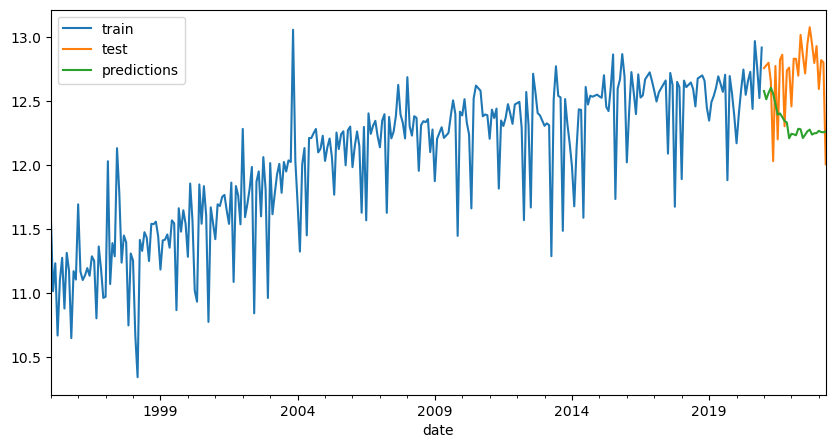

In [47]:
# Prediction
steps = 24 + 4
predictions = forecaster.predict(steps=steps)

# Plot predictions versus test data
# ==================================================
fig, ax = plt.subplots(figsize=(10, 5))
data['log_mean_price'].plot(ax=ax, label='train')
data_test['log_mean_price'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()
plt.show()


In [48]:
from sklearn.metrics import mean_squared_error

# Test error
# ===============================================
error_mse = mean_squared_error(
                y_true = data_test['log_mean_price'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 0.2397466226768911


#### Hyperparameter tuning

In [49]:
from skforecast.model_selection import grid_search_forecaster

#  Hyperparameters: grid search
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 12 # This value will be replaced in the grid search
             )

# Candidate values for lags
lags_grid = [4, 6, 12, 24]

# Candidate values for regressor's hyperparameters
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 8, 16]
}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data['log_mean_price'],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = steps,
                   metric             = 'mean_squared_error',
                   initial_train_size = int(len(data)*0.5),
                   fixed_train_size   = False,
                   refit              = False,
                   skip_folds         = None,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False
               )

print("--------------------------- Results ---------------------------")
results_grid.head(3)

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'max_depth': 8, 'n_estimators': 100}
  Backtesting metric: 0.1036400142567269

--------------------------- Results ---------------------------


,lags,lags_label,params,mean_squared_error,max_depth,n_estimators
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 8, 'n_estimators': 100}",0.103640,8,100
23,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 16, 'n_estimators': 100}",0.105575,16,100
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 8, 'n_estimators': 100}",0.107776,8,100


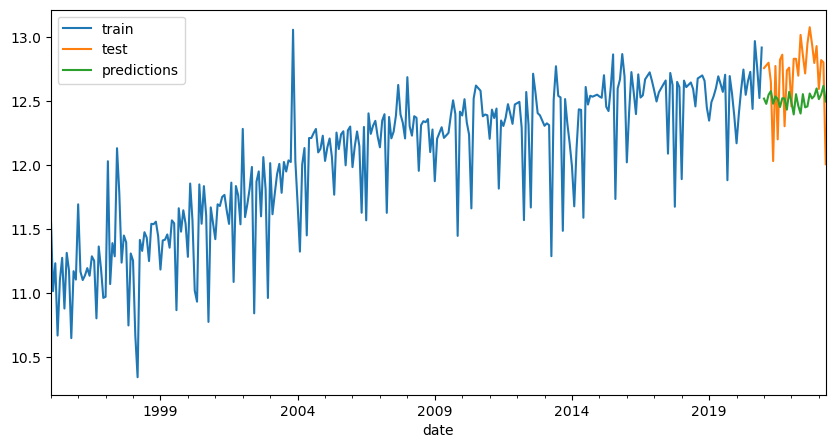

Test error (MSE): 0.10984495867416903


In [50]:
# Create and train forecaster with the best hyperparameters and lags found
# ==============================================================================
regressor = RandomForestRegressor(n_estimators=250, max_depth=8, random_state=123)
forecaster = ForecasterAutoreg(
                 regressor = regressor,
                 lags      = 20
             )
forecaster.fit(y=data['log_mean_price'])

# Predictions
# ==============================================================================
steps = 24 + 4
predictions = forecaster.predict(steps=steps)

# Plot predictions versus test data
# ==================================================
fig, ax = plt.subplots(figsize=(10, 5))
data['log_mean_price'].plot(ax=ax, label='train')
data_test['log_mean_price'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()
plt.show()

# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['log_mean_price'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 204
Number of observations used for backtesting: 108
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 36
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1995-01-01 00:00:00 -- 2011-12-01 00:00:00  (n=204)
    Validation: 2012-01-01 00:00:00 -- 2014-12-01 00:00:00  (n=36)
Fold: 1
    Training:   1995-01-01 00:00:00 -- 2014-12-01 00:00:00  (n=240)
    Validation: 2015-01-01 00:00:00 -- 2017-12-01 00:00:00  (n=36)
Fold: 2
    Training:   1995-01-01 00:00:00 -- 2017-12-01 00:00:00  (n=276)
    Validation: 2018-01-01 00:00:00 -- 2020-12-01 00:00:00  (n=36)



  0%|          | 0/3 [00:00<?, ?it/s]

   mean_squared_error
0            0.116924


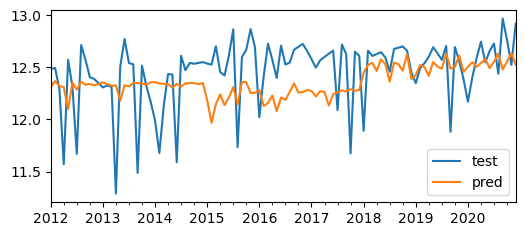

In [51]:
from skforecast.model_selection import backtesting_forecaster

#  Backtesting
# ==============================================================================
steps = 36
n_backtesting = 36*3 # The last 9 years are separated for the backtest
metric, predictions_backtest = backtesting_forecaster(
                                   forecaster         = forecaster,
                                   y                  = data['log_mean_price'],
                                   initial_train_size = len(data) - n_backtesting,
                                   fixed_train_size   = False,
                                   steps              = steps,
                                   metric             = 'mean_squared_error',
                                   refit              = True,
                                   verbose            = True,
                                   show_progress      = True
                               )
print(metric)

# Plot backtest predictions vs real values
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data.loc[predictions_backtest.index, 'log_mean_price'].plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

#### Extensión de variables a test (2020 en adelante)

In [52]:
def get_future_prediction(df, var):
    #  Hyperparameters: grid search
    # ==============================================================================
    y = df[var]
    steps = 36
    forecaster = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=123),
                    lags      = 12 # This value will be replaced in the grid search
                )

    # Candidate values for lags
    lags_grid = [4, 6, 12, 24]

    # Candidate values for regressor's hyperparameters
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [3, 8, 16]
    }

    results_grid = grid_search_forecaster(
                    forecaster         = forecaster,
                    y                  = y,
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    steps              = steps,
                    metric             = 'mean_squared_error',
                    initial_train_size = int(len(df)*0.5),
                    fixed_train_size   = False,
                    refit              = False,
                    skip_folds         = None,
                    return_best        = True,
                    n_jobs             = 'auto',
                    verbose            = False
                )

    # Results
    results_grid = results_grid.reset_index()
    lags = results_grid["lags"][0][-1]
    max_depth = results_grid["max_depth"][0]
    n_estimators = results_grid["n_estimators"][0]

    # Create and train forecaster with the best hyperparameters and lags found
    # ==============================================================================
    regressor = RandomForestRegressor(n_estimators=n_estimators, 
                                      max_depth=max_depth, 
                                      random_state=123)
    forecaster = ForecasterAutoreg(
                    regressor = regressor,
                    lags      = 20
                )
    forecaster.fit(y=data[var])

    # Predictions
    # ==============================================================================
    steps = 24 + 4
    return forecaster.predict(steps=steps)

In [53]:
for var in log_vars_forecast:
    data_test["pred_"+var] = get_future_prediction(data, var)

data_test.head()

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 0.04979209643071952

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 16, 'n_estimators': 100}
  Backtesting metric: 0.10926733277162211

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'max_depth': 8, 'n_estimators': 100}
  Backtesting metric: 0.1036400142567269



,q1,q3,mean_price,log_q1,log_q3,log_mean_price,pred_log_q1,pred_log_q3,pred_log_mean_price
date,,,,,,,,,
2021-01-01,255000.0,360000.0,347300.000000,12.449019,12.793859,12.757944,11.928336,12.759628,12.517974
2021-02-01,176250.0,450000.0,354638.874150,12.079659,13.017003,12.778855,11.929819,12.431967,12.463109
2021-03-01,174750.0,426250.0,362128.349862,12.071112,12.962781,12.799754,11.923597,12.625480,12.511702
2021-04-01,170000.0,380000.0,312351.346414,12.043554,12.847927,12.651884,11.881357,12.697297,12.562314
2021-05-01,168000.0,168000.0,168000.000000,12.031719,12.031719,12.031719,11.885482,12.566550,12.434151


### Join de las nuevas variables

Train solo tiene datos hasta 2020, pero test a partir de ese año. Vamos a usar por tanto la media histórica:

In [54]:
data_test = data_test.reset_index()
data_test["Year"] = data_test["date"].dt.year
data_test["month"] = data_test["date"].dt.month
data_test.head()

,date,q1,q3,mean_price,log_q1,log_q3,log_mean_price,pred_log_q1,pred_log_q3,pred_log_mean_price,Year,month
0,2021-01-01,255000.0,360000.0,347300.000000,12.449019,12.793859,12.757944,11.928336,12.759628,12.517974,2021,1
1,2021-02-01,176250.0,450000.0,354638.874150,12.079659,13.017003,12.778855,11.929819,12.431967,12.463109,2021,2
2,2021-03-01,174750.0,426250.0,362128.349862,12.071112,12.962781,12.799754,11.923597,12.625480,12.511702,2021,3
3,2021-04-01,170000.0,380000.0,312351.346414,12.043554,12.847927,12.651884,11.881357,12.697297,12.562314,2021,4
4,2021-05-01,168000.0,168000.0,168000.000000,12.031719,12.031719,12.031719,11.885482,12.566550,12.434151,2021,5


Join con test:

In [55]:
log_vars_forecast

['log_q1', 'log_q3', 'log_mean_price']

In [56]:
pred_log_vars_forecast = ["pred_"+var for var in log_vars_forecast]
corrections = {k: v for k,v in zip(pred_log_vars_forecast, log_vars_forecast)}

q1_q3_test = data_test.reset_index().\
    loc[:, ["Year", "month"]+pred_log_vars_forecast].\
        rename(columns=corrections)

# Save results
with open('../output/q1_q3_test.pkl', 'wb') as f:
            pickle.dump(q1_q3_test, f)

q1_q3_test.head()

,Year,month,log_q1,log_q3,log_mean_price
0,2021,1,11.928336,12.759628,12.517974
1,2021,2,11.929819,12.431967,12.463109
2,2021,3,11.923597,12.625480,12.511702
3,2021,4,11.881357,12.697297,12.562314
4,2021,5,11.885482,12.566550,12.434151


In [57]:
if "log_q1" not in test_df.columns:
    test_df = pd.merge(left=test_df, 
                       right=q1_q3_test, 
                       on=["Year", "month"], how="left")

for v, v_log in zip(vars_forecast, log_vars_forecast):
    test_df[v] = np.exp(test_df[v_log])

test_df.head()

,Price,date,Postcode,Property.Type,Old.New,Duration,PAON,SAON,Street,Locality,...,Year,month,day,date2,log_q1,log_q3,log_mean_price,q1,q3,mean_price
0,234000,2021-01-01,L36 9AD,Unifamiliar,Segunda_mano,Alquiler,36,NaN,springwell avenue,NaN,...,2021,1,1,2021-01,11.928336,12.759628,12.517974,151499.304088,347885.18368,273204.058599
1,255000,2021-01-01,TR26 2SX,Piso/Apartamento,Segunda_mano,Alquiler,bay villas,2,st ives road,carbis bay,...,2021,1,1,2021-01,11.928336,12.759628,12.517974,151499.304088,347885.18368,273204.058599
2,360000,2021-01-01,BR4 9PU,Piso/Apartamento,Segunda_mano,Alquiler,"st. williams court, 2",flat 3,grosvenor road,NaN,...,2021,1,1,2021-01,11.928336,12.759628,12.517974,151499.304088,347885.18368,273204.058599
3,590000,2021-01-01,BR6 0EN,Semi-adosado,Segunda_mano,Propiedad,47,NaN,broomhill road,NaN,...,2021,1,1,2021-01,11.928336,12.759628,12.517974,151499.304088,347885.18368,273204.058599
4,297500,2021-01-01,CV9 1NZ,Semi-adosado,Segunda_mano,Propiedad,42,NaN,mancetter road,NaN,...,2021,1,1,2021-01,11.928336,12.759628,12.517974,151499.304088,347885.18368,273204.058599


Finalmente, vamos a crear las columnas is_top_outlier e is_bottom_outlier en test:

In [58]:
test_df["IQR"] = test_df["q3"] - test_df["q1"]

test_df.loc[:, "is_top_outlier"] = (test_df["Price"] > (test_df["q3"] + 1.5 * test_df["IQR"])).astype("int")
test_df.loc[:, "is_bottom_outlier"] = (test_df["Price"] < (test_df["q1"] - 1.5 * test_df["IQR"])).astype("int")
test_df.drop(["IQR"], axis=1, inplace=True) # b/c is linear combination of q1 and q3

test_df.head()

,Price,date,Postcode,Property.Type,Old.New,Duration,PAON,SAON,Street,Locality,...,day,date2,log_q1,log_q3,log_mean_price,q1,q3,mean_price,is_top_outlier,is_bottom_outlier
0,234000,2021-01-01,L36 9AD,Unifamiliar,Segunda_mano,Alquiler,36,NaN,springwell avenue,NaN,...,1,2021-01,11.928336,12.759628,12.517974,151499.304088,347885.18368,273204.058599,0,0
1,255000,2021-01-01,TR26 2SX,Piso/Apartamento,Segunda_mano,Alquiler,bay villas,2,st ives road,carbis bay,...,1,2021-01,11.928336,12.759628,12.517974,151499.304088,347885.18368,273204.058599,0,0
2,360000,2021-01-01,BR4 9PU,Piso/Apartamento,Segunda_mano,Alquiler,"st. williams court, 2",flat 3,grosvenor road,NaN,...,1,2021-01,11.928336,12.759628,12.517974,151499.304088,347885.18368,273204.058599,0,0
3,590000,2021-01-01,BR6 0EN,Semi-adosado,Segunda_mano,Propiedad,47,NaN,broomhill road,NaN,...,1,2021-01,11.928336,12.759628,12.517974,151499.304088,347885.18368,273204.058599,0,0
4,297500,2021-01-01,CV9 1NZ,Semi-adosado,Segunda_mano,Propiedad,42,NaN,mancetter road,NaN,...,1,2021-01,11.928336,12.759628,12.517974,151499.304088,347885.18368,273204.058599,0,0


### Análisis exploratorio de los outliers:

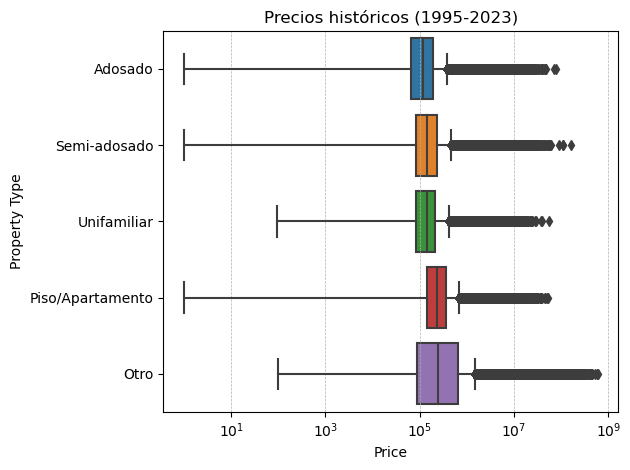

In [59]:
# https://www.geeksforgeeks.org/horizontal-boxplots-with-seaborn-in-python/
# https://stackoverflow.com/questions/28615887/how-to-move-a-tick-label
# https://stackoverflow.com/questions/42973223/how-to-share-x-axes-of-two-subplots-after-they-have-been-created

(fig, ax) = plt.subplots(1, sharex=True)

# Prices between 1995 and 2023
x_name = "Price"
y_name = "Property Type"
sns.boxplot(data = load_vars([x_name, y_name]), 
            y=y_name, x=x_name, 
            orient="h", ax=ax)

ax.set_yticklabels({"Adosado": "T", "Semi-adosado": "S", "Unifamiliar": "D",
                    "Piso/Apartamento": "F", "Otro": "O"})
ax.set_xscale("log")
ax.set_title("Precios históricos (1995-2023)")
ax.grid(axis = 'x', linestyle = '--', linewidth = 0.5)

# Show plot
plt.tight_layout()
plt.show()

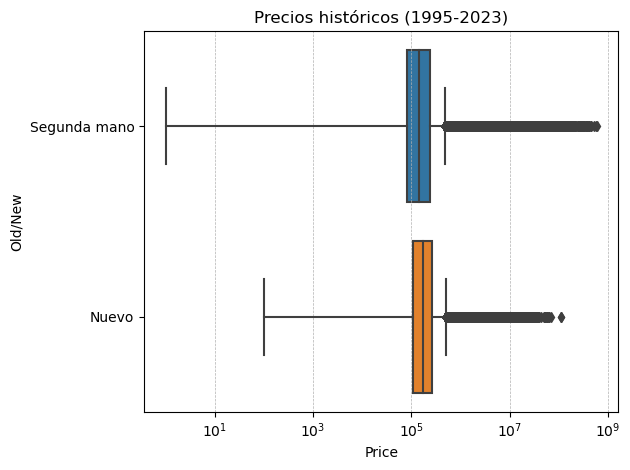

In [60]:
# https://www.geeksforgeeks.org/horizontal-boxplots-with-seaborn-in-python/
# https://stackoverflow.com/questions/28615887/how-to-move-a-tick-label
# https://stackoverflow.com/questions/42973223/how-to-share-x-axes-of-two-subplots-after-they-have-been-created

(fig, ax) = plt.subplots(1, sharex=True)

# Prices between 1995 and 2023
x_name = "Price"
y_name = "Old/New"
sns.boxplot(data = load_vars([x_name, y_name]), 
            y=y_name, x=x_name, 
            orient="h", ax=ax)

ax.set_yticklabels({"Segunda mano": "N", "Nuevo": "Y"})
ax.set_xscale("log")
ax.set_title("Precios históricos (1995-2023)")
ax.grid(axis = 'x', linestyle = '--', linewidth = 0.5)

# Show plot
plt.tight_layout()
plt.show()

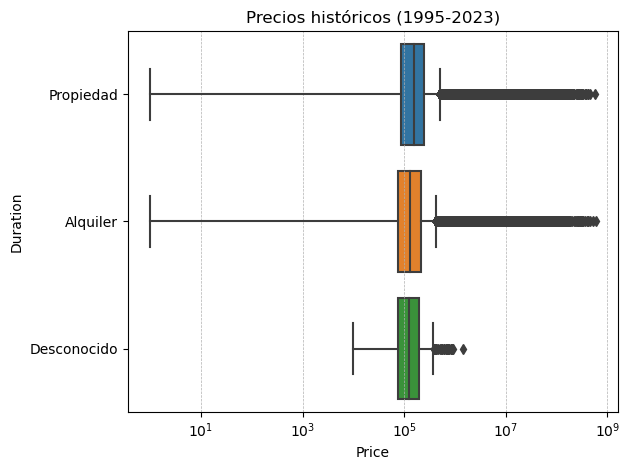

In [61]:
# https://www.geeksforgeeks.org/horizontal-boxplots-with-seaborn-in-python/
# https://stackoverflow.com/questions/28615887/how-to-move-a-tick-label
# https://stackoverflow.com/questions/42973223/how-to-share-x-axes-of-two-subplots-after-they-have-been-created

(fig, ax) = plt.subplots(1, sharex=True)

# Prices between 1995 and 2023
x_name = "Price"
y_name = "Duration"
sns.boxplot(data = load_vars([x_name, y_name]), 
            y=y_name, x=x_name, 
            orient="h", ax=ax)

ax.set_yticklabels({"Propiedad": "F", "Alquiler": "L", "Desconocido": "U"})
ax.set_xscale("log")
ax.set_title("Precios históricos (1995-2023)")
ax.grid(axis = 'x', linestyle = '--', linewidth = 0.5)

# Show plot
plt.tight_layout()
plt.show()

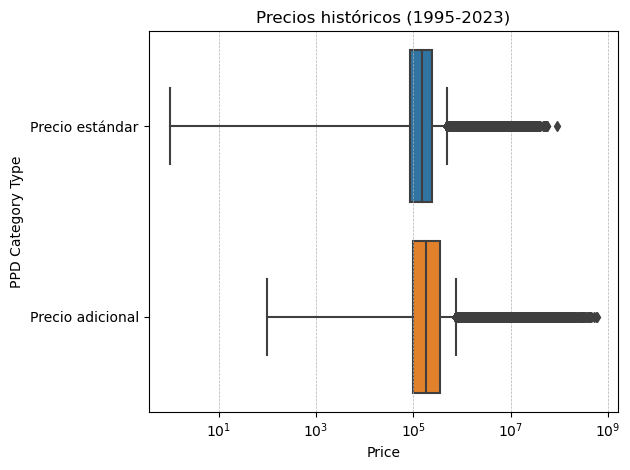

In [62]:
# https://www.geeksforgeeks.org/horizontal-boxplots-with-seaborn-in-python/
# https://stackoverflow.com/questions/28615887/how-to-move-a-tick-label
# https://stackoverflow.com/questions/42973223/how-to-share-x-axes-of-two-subplots-after-they-have-been-created

(fig, ax) = plt.subplots(1, sharex=True)

# Prices between 1995 and 2023
x_name = "Price"
y_name = "PPD Category Type"
sns.boxplot(data = load_vars([x_name, y_name]), 
            y=y_name, x=x_name, 
            orient="h", ax=ax)

ax.set_yticklabels({"Precio estándar": "A", "Precio adicional": "B"})
ax.set_xscale("log")
ax.set_title("Precios históricos (1995-2023)")
ax.grid(axis = 'x', linestyle = '--', linewidth = 0.5)

# Show plot
plt.tight_layout()
plt.show()

In [63]:
train_df.to_csv("../output/R/outliers.csv", index=False)

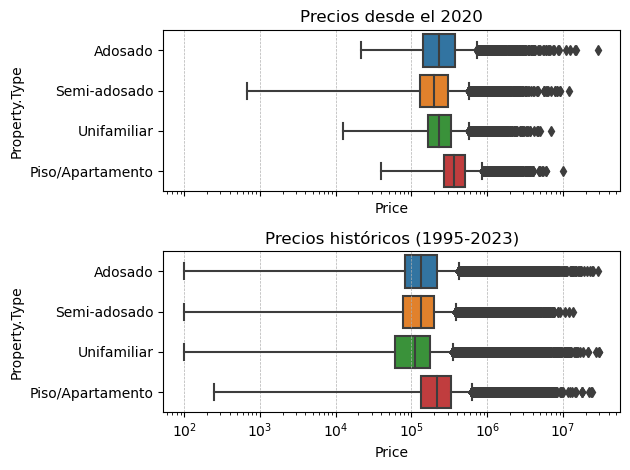

In [64]:
# https://www.geeksforgeeks.org/horizontal-boxplots-with-seaborn-in-python/
# https://stackoverflow.com/questions/28615887/how-to-move-a-tick-label
# https://stackoverflow.com/questions/42973223/how-to-share-x-axes-of-two-subplots-after-they-have-been-created

(fig, axs) = plt.subplots(2, sharex=True)
ax1 = axs[0]
ax2 = axs[1]

# Prices between 2020 and 2023
sns.boxplot(data = train_df.loc[train_df["Year"] >= 2020,:], 
            y="Property.Type", x="Price", orient="h", ax=ax1)

ax1.set_yticklabels(["Adosado","Semi-adosado","Unifamiliar","Piso/Apartamento"])
ax1.set_xscale("log")
ax1.set_title("Precios desde el 2020")
ax1.grid(axis = 'x', linestyle = '--', linewidth = 0.5)

# Prices between 1995 and 2023
sns.boxplot(data = train_df, 
            y="Property.Type", x="Price", orient="h", ax=ax2)

ax2.set_yticklabels(["Adosado","Semi-adosado","Unifamiliar","Piso/Apartamento"])
ax2.set_xscale("log")
ax2.set_title("Precios históricos (1995-2023)")
ax2.grid(axis = 'x', linestyle = '--', linewidth = 0.5)

# Show plot
plt.tight_layout()
plt.show()

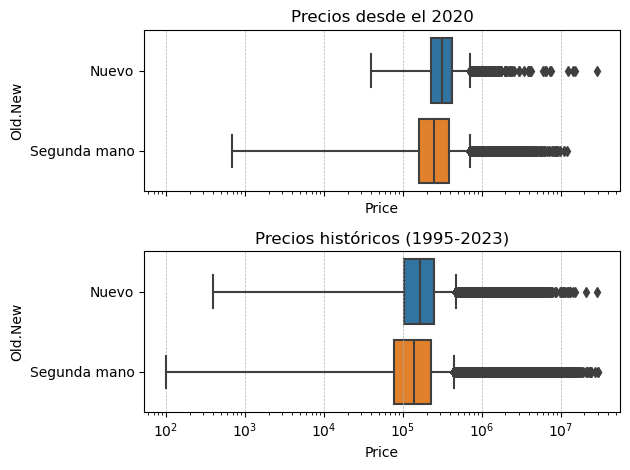

In [65]:
# https://www.geeksforgeeks.org/horizontal-boxplots-with-seaborn-in-python/
# https://stackoverflow.com/questions/28615887/how-to-move-a-tick-label
# https://stackoverflow.com/questions/42973223/how-to-share-x-axes-of-two-subplots-after-they-have-been-created

(fig, axs) = plt.subplots(2, sharex=True)
ax1 = axs[0]
ax2 = axs[1]

# Prices between 2020 and 2023
sns.boxplot(data = train_df.loc[train_df["Year"] >= 2020,:], 
            y="Old.New", x="Price", orient="h", ax=ax1,
            order=["Nuevo", "Segunda_mano"])

ax1.set_yticklabels(["Nuevo", "Segunda mano"])
ax1.set_xscale("log")
ax1.set_title("Precios desde el 2020")
ax1.grid(axis = 'x', linestyle = '--', linewidth = 0.5)

# Prices between 1995 and 2023
sns.boxplot(data = train_df, 
            y="Old.New", x="Price", orient="h", ax=ax2,
            order=["Nuevo", "Segunda_mano"])

ax2.set_yticklabels(["Nuevo", "Segunda mano"])
ax2.set_xscale("log")
ax2.set_title("Precios históricos (1995-2023)")
ax2.grid(axis = 'x', linestyle = '--', linewidth = 0.5)

# Show plot
plt.tight_layout()
plt.show()

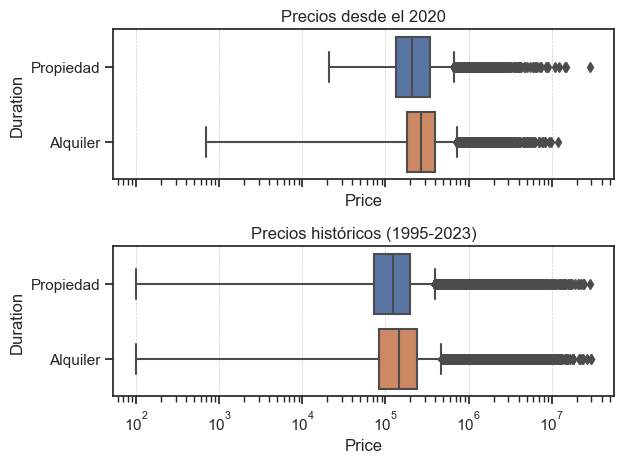

In [66]:
# https://www.geeksforgeeks.org/horizontal-boxplots-with-seaborn-in-python/
# https://stackoverflow.com/questions/28615887/how-to-move-a-tick-label
# https://stackoverflow.com/questions/42973223/how-to-share-x-axes-of-two-subplots-after-they-have-been-created

sns.set_theme(style="ticks")

(fig, axs) = plt.subplots(2, sharex=True)
ax1 = axs[0]
ax2 = axs[1]

# Prices between 2020 and 2023
sns.boxplot(data = train_df.loc[train_df["Year"] >= 2020,:], 
            y="Duration", x="Price", orient="h", ax=ax1)

ax1.set_yticklabels(["Propiedad", "Alquiler"])
ax1.set_xscale("log")
ax1.set_title("Precios desde el 2020")
ax1.grid(axis = 'x', linestyle = '--', linewidth = 0.5)

# Prices between 1995 and 2023
sns.boxplot(data = train_df, 
            y="Duration", x="Price", orient="h", ax=ax2)

ax2.set_yticklabels(["Propiedad", "Alquiler"])
ax2.set_xscale("log")
ax2.set_title("Precios históricos (1995-2023)")
ax2.grid(axis = 'x', linestyle = '--', linewidth = 0.5)

# Show plot
plt.tight_layout()
plt.show()

In [67]:
# Podemos añadir los boxplots de otras variables de interés, como is_coastal, is_isle o First_hand

## Datos geográficos

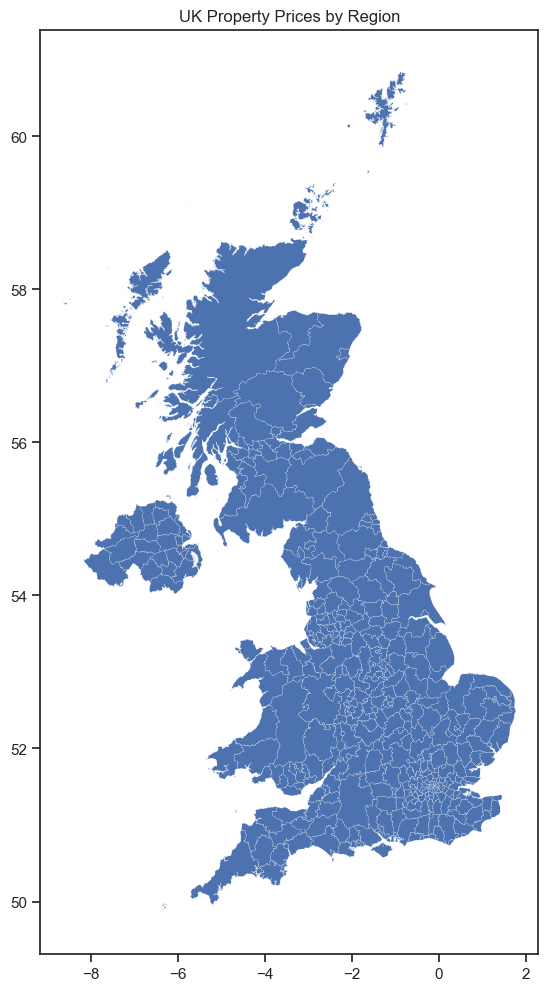

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
uk_geo.plot(ax=ax, linewidth=0.1)

plt.title('UK Property Prices by Region')
plt.show()



In [69]:
temp = load_vars(["District", "Price", "Date of Transfer"])
temp["District"] = temp["District"].str.lower()
temp.loc[:, "District"] = temp.loc[:, "District"].replace(to_replace="the wrekin",
                                                      value="wrekin")
temp["Year"] = pd.to_datetime(temp["Date of Transfer"]).dt.year
temp.head()

,Price,Date of Transfer,District,Year
0,35000,1995-01-01 00:00,plymouth,1995
1,50000,1995-01-01 00:00,bristol,1995
2,18500,1995-01-01 00:00,the east yorkshire borough of beverley,1995
3,28000,1995-01-01 00:00,wakefield,1995
4,34950,1995-01-01 00:00,corby,1995


Unimos los datos para dar los mapas de precios por distritos históricos y a partir del 2020:

In [70]:
temp.loc[temp["Year"] > 2020, ["District", "Price"]].\
        groupby("District").agg(Precio_medio = ("Price", np.mean)).\
            reset_index()

,District,Precio_medio
0,adur,398412.543594
1,allerdale,220547.592091
2,amber valley,259229.476612
3,arun,414283.363575
4,ashfield,216342.882186
...,...,...
337,wrexham,272618.218064
338,wychavon,375968.857287
339,wyre,223906.814319
340,wyre forest,274906.529811


In [71]:
test_df.loc[test_df["Year"] > 2020, ["District", "Price"]].\
        groupby("District").agg(Precio_medio = ("Price", np.mean)).\
            reset_index()

,District,Precio_medio
0,adur,405537.061404
1,allerdale,201683.199367
2,amber valley,240139.701987
3,arun,379380.826149
4,ashfield,191097.869565
...,...,...
337,wrexham,205667.037037
338,wychavon,371249.633708
339,wyre,209763.939076
340,wyre forest,255197.258993


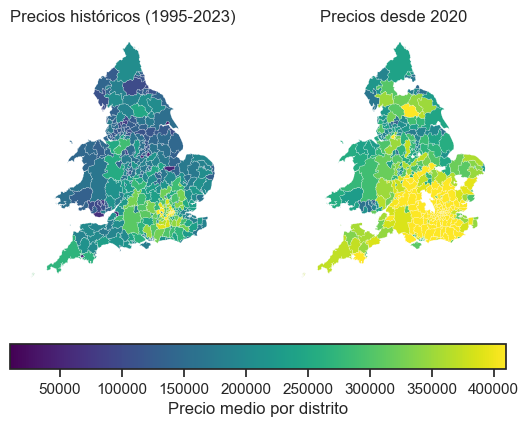

In [72]:
# https://www.geeksforgeeks.org/horizontal-boxplots-with-seaborn-in-python/
# https://stackoverflow.com/questions/28615887/how-to-move-a-tick-label
# https://stackoverflow.com/questions/42973223/how-to-share-x-axes-of-two-subplots-after-they-have-been-created

(fig, axs) = plt.subplots(ncols=2)
ax1 = axs[0]
ax2 = axs[1]

# Calculate the min and max values for the color scale
vmin = temp.loc[temp["Year"], "Price"].min()
vmax = temp.loc[temp["Year"], "Price"].max()

# All data map
im = pd.merge(
    left=uk_geo,
    right=temp.loc[:, ["District", "Price"]].\
        groupby("District").agg(Precio_medio = ("Price", np.mean)).\
            reset_index(),
    how="left", left_on="NAME_3" , right_on="District"
).plot(
    column="Precio_medio", ax=ax1, linewidth=0.1,
    cmap="viridis", vmin=vmin, vmax=vmax
)

# From 2020 data map
im = pd.merge(
    left=uk_geo,
    right=temp.loc[temp["Year"] > 2020, ["District", "Price"]].\
        groupby("District").agg(Precio_medio = ("Price", np.mean)).\
            reset_index(),
    how="left", left_on="NAME_3" , right_on="District"
).plot(
    column="Precio_medio", ax=ax2, linewidth=0.1,
    cmap="viridis", vmin=vmin, vmax=vmax
)

# Create a colorbar for both plots
fig.colorbar(im.collections[0], ax=[ax1, ax2], 
             orientation='horizontal', label="Precio medio por distrito")

# Show plot
ax1.axis("off")
ax1.set_title("Precios históricos (1995-2023)")
ax2.axis("off")
ax2.set_title("Precios desde 2020")
# plt.tight_layout()
plt.show()

# Preprocesamiento de los datos

## Preprocesamiento de los datos de Kaggle

Tenemos que transformar varias variables de los datos para poder usarlas. Concretamente haremos:
+ Codificado de Duration y Property.Type.
+ Transformar a variables binarias Old.New y PPD.Category.Type.
+ Normalizar la variable Price (variable objetivo).
+ Tratar los outliers.
+ Tratar los datos faltantes.

### Codificación

In [73]:
def kaggle_encoding(datos, drop_redundant=False):
    df = datos.copy()

    # Binary encoding: Old.New, PPD.Category.Type
    df["First_hand"] = (df["Old.New"] == "Nuevo").astype("int")
    df["Paid_Additional_Price"] = (df["PPD.Category.Type"] == "B").astype("int")

    # Label encoding: Duration, Property.Type
    # https://datascience.stackexchange.com/questions/81490/encoding-categorical-data-with-pre-determined-dictionary
    mapping = {
        "Duration": {"Propiedad": 0, "Alquiler": 1, "Desconocido": 2},
        "Property.Type": {"Adosado": 0, "Semi-adosado": 1, "Unifamiliar": 2, 
                          "Piso/Apartamento": 3, "Otro": 4}
    }
    df["org_property_type"] = df["Property.Type"]
    df["org_duration"] = df["Duration"]
    df.replace(mapping, inplace=True)

    # Drop redundant
    if drop_redundant:
        redundant_variables = ["Old.New", "PPD.Category.Type"]
        to_drop = [var for var in redundant_variables if var in df.columns]
        df.drop(labels=to_drop, axis=1, inplace=True)
    
    return df

train_df = kaggle_encoding(train_df, drop_redundant=True)
test_df = kaggle_encoding(test_df, drop_redundant=True)
train_df.head()

,Price,date,Postcode,Property.Type,Duration,PAON,SAON,Street,Locality,Town.City,...,date2,q1,q3,is_top_outlier,is_bottom_outlier,mean_price,First_hand,Paid_Additional_Price,org_property_type,org_duration
0,300000,1995-01-01,SW19 5JU,3,1,1,flat 6,somerset road,london,london,...,1995-01,47125.0,143750.0,1,0,112464.285714,1,0,Piso/Apartamento,Alquiler
1,70500,1995-01-01,RH12 1DD,1,0,3,NaN,wellington road,horsham,horsham,...,1995-01,47125.0,143750.0,0,0,112464.285714,0,0,Semi-adosado,Propiedad
2,35000,1995-01-01,WF12 0LJ,0,0,42,NaN,the common,dewsbury,dewsbury,...,1995-01,47125.0,143750.0,0,0,112464.285714,0,0,Adosado,Propiedad
3,41000,1995-01-01,GL4 0XW,1,0,224,NaN,bodiam avenue,tuffley,gloucester,...,1995-01,47125.0,143750.0,0,0,112464.285714,0,0,Semi-adosado,Propiedad
4,125000,1995-01-01,SK10 1QL,2,0,28,NaN,lark hall road,macclesfield,macclesfield,...,1995-01,47125.0,143750.0,0,0,112464.285714,0,0,Unifamiliar,Propiedad


### Normalización de la variable Price

In [74]:
from scipy import stats
def inv_boxcox(y, lambda_param):
    if lambda_param == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lambda_param * y + 1) / lambda_param)

transformed_data, lambda_boxcox = stats.boxcox(train_df["Price"])
inverse_transformed_data = inv_boxcox(transformed_data, lambda_boxcox)

# Save results
with open('../output/lambda_boxcox.pkl', 'wb') as f:
            pickle.dump(lambda_boxcox, f)
lambda_boxcox


0.02103717866446626

Al tener lambda prácticamente cero, tenemos una transformación similar a la logarítmica.

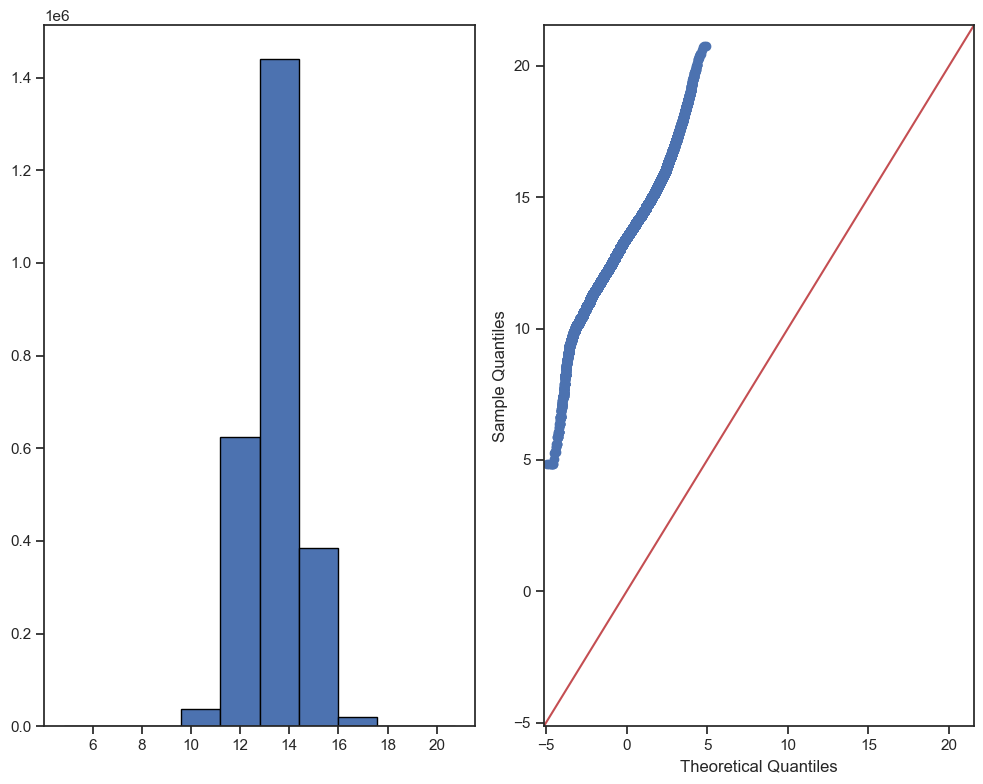

In [75]:
temp = transformed_data
fig, ax = plt.subplots(ncols=2, figsize=(10, 8))

ax[0].hist(temp, edgecolor='black')

sm.qqplot(temp, line="45", ax=ax[1])

plt.tight_layout()
plt.show()
del temp, transformed_data, inverse_transformed_data

In [76]:
# Podría aprovecharse para representar varios casos. Por ejemplo, los que se muestran en la tabla 1 del trabajo
# https://www.iaeng.org/publication/WCE2021/WCE2021_pp101-106.pdf

Aplicamos la transformación BoxCox a los datos:

In [77]:
def create_price_boxcox(df, drop_redundant=False):
    df["Price_boxcox"] = stats.boxcox(x=df["Price"], lmbda=lambda_boxcox)

    if drop_redundant:
        df.drop("Price", axis=1, inplace=True)

create_price_boxcox(train_df)
create_price_boxcox(test_df)
train_df.head()

,Price,date,Postcode,Property.Type,Duration,PAON,SAON,Street,Locality,Town.City,...,q1,q3,is_top_outlier,is_bottom_outlier,mean_price,First_hand,Paid_Additional_Price,org_property_type,org_duration,Price_boxcox
0,300000,1995-01-01,SW19 5JU,3,1,1,flat 6,somerset road,london,london,...,47125.0,143750.0,1,0,112464.285714,1,0,Piso/Apartamento,Alquiler,14.442841
1,70500,1995-01-01,RH12 1DD,1,0,3,NaN,wellington road,horsham,horsham,...,47125.0,143750.0,0,0,112464.285714,0,0,Semi-adosado,Propiedad,12.583137
2,35000,1995-01-01,WF12 0LJ,0,0,42,NaN,the common,dewsbury,dewsbury,...,47125.0,143750.0,0,0,112464.285714,0,0,Adosado,Propiedad,11.703994
3,41000,1995-01-01,GL4 0XW,1,0,224,NaN,bodiam avenue,tuffley,gloucester,...,47125.0,143750.0,0,0,112464.285714,0,0,Semi-adosado,Propiedad,11.901504
4,125000,1995-01-01,SK10 1QL,2,0,28,NaN,lark hall road,macclesfield,macclesfield,...,47125.0,143750.0,0,0,112464.285714,0,0,Unifamiliar,Propiedad,13.311820


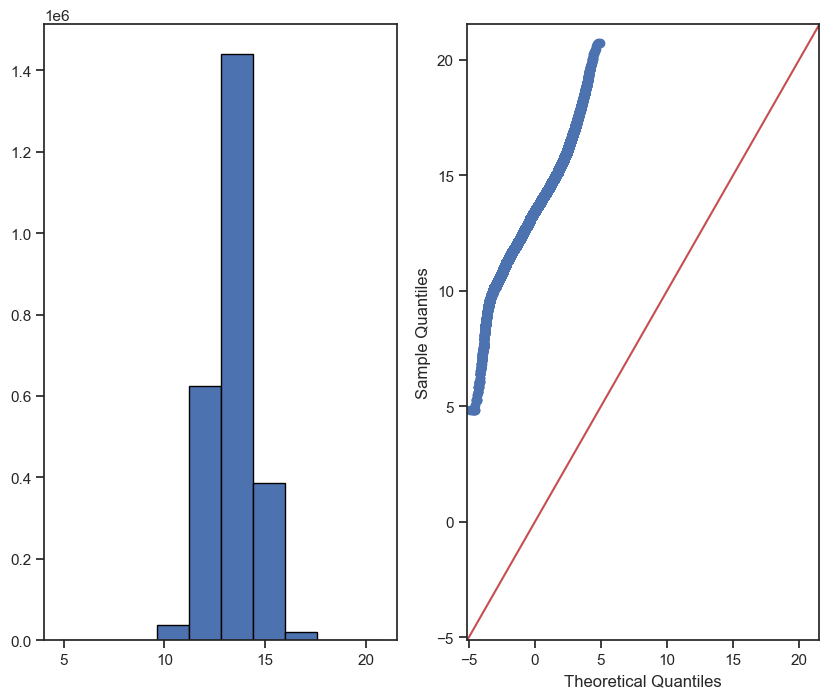

In [78]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 8))

ax[0].hist(train_df["Price_boxcox"], edgecolor='black')

import statsmodels.api as sm
sm.qqplot(train_df["Price_boxcox"], line="45", ax=ax[1])

plt.show()

In [79]:
train_df.loc[:, ("Price", "Price_boxcox")].to_csv("../output/R/price_vs_price_boxcox.csv")


### Datos faltantes

No vamos a construir modelos con una granularidad tan alta, así que no son problemáticos. De hecho, podemos eliminar estas columnas:

In [80]:
def kaggle_drop_columns(df):
    proposed = ["PAON", "SAON", "Postcode", "Locality", "Street"]
    to_drop = [var for var in proposed if var in df.columns]
    df.drop(to_drop, axis=1, inplace=True)

kaggle_drop_columns(train_df)
kaggle_drop_columns(test_df)
train_df.head()

,Price,date,Property.Type,Duration,Town.City,District,County,Year,month,day,...,q1,q3,is_top_outlier,is_bottom_outlier,mean_price,First_hand,Paid_Additional_Price,org_property_type,org_duration,Price_boxcox
0,300000,1995-01-01,3,1,london,merton,greater london,1995,1,1,...,47125.0,143750.0,1,0,112464.285714,1,0,Piso/Apartamento,Alquiler,14.442841
1,70500,1995-01-01,1,0,horsham,horsham,west sussex,1995,1,1,...,47125.0,143750.0,0,0,112464.285714,0,0,Semi-adosado,Propiedad,12.583137
2,35000,1995-01-01,0,0,dewsbury,kirklees,west yorkshire,1995,1,1,...,47125.0,143750.0,0,0,112464.285714,0,0,Adosado,Propiedad,11.703994
3,41000,1995-01-01,1,0,gloucester,gloucester,gloucestershire,1995,1,1,...,47125.0,143750.0,0,0,112464.285714,0,0,Semi-adosado,Propiedad,11.901504
4,125000,1995-01-01,2,0,macclesfield,macclesfield,cheshire,1995,1,1,...,47125.0,143750.0,0,0,112464.285714,0,0,Unifamiliar,Propiedad,13.311820


## Join

Primero uniremos los datos de Kaggle con los datos censales. Después, estudiaremos si esto añade datos faltantes y, tras tratarlos, escalaremos las variables numéricas.

In [81]:
census_df

,District,total_people,people_working,people_studying,total_houses,BandA,BandB,BandC,BandD,BandE,BandF,BandG,job_density,density_population_hectare
0,hartlepool,95400.000000,41200.000000,41200.000000,25868.000000,0.300000,11.800000,32.300000,41.000000,12.300000,1.90000,0.500000,0.600000,9.8
1,middlesbrough,152700.000000,60400.000000,60400.000000,39510.000000,0.200000,12.800000,32.200000,40.500000,12.400000,1.40000,0.400000,0.790000,25.7
2,redcar and cleveland,137900.000000,64500.000000,64500.000000,32677.000000,0.200000,12.200000,28.400000,41.300000,14.800000,2.50000,0.700000,0.550000,5.5
3,stockton-on-tees,202400.000000,90400.000000,90400.000000,48149.000000,0.200000,12.700000,33.400000,41.200000,10.800000,1.30000,0.300000,0.780000,9.4
4,darlington,110600.000000,55000.000000,55000.000000,28777.000000,0.300000,14.200000,28.900000,38.800000,14.900000,2.30000,0.600000,0.870000,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,purbeck,381536.677116,184643.939394,184643.939394,42462.166163,0.331722,14.186103,30.255891,38.450151,13.375529,2.62145,0.776737,1.153373,1.1
358,west dorset,381536.677116,184643.939394,184643.939394,42462.166163,0.331722,14.186103,30.255891,38.450151,13.375529,2.62145,0.776737,1.153373,0.9
359,weymouth and portland,381536.677116,184643.939394,184643.939394,42462.166163,0.331722,14.186103,30.255891,38.450151,13.375529,2.62145,0.776737,1.153373,15.6
360,taunton deane,381536.677116,184643.939394,184643.939394,42462.166163,0.331722,14.186103,30.255891,38.450151,13.375529,2.62145,0.776737,1.153373,2.4


In [82]:
def join_census(df):
    temp = pd.merge(
        left=df,
        right=census_df,
        how="left", on="District"
    )
    temp[census_numeric_columns] = temp[census_numeric_columns].fillna(temp[census_numeric_columns].mean())
    return temp
train_df = join_census(train_df)
test_df = join_census(test_df)
train_df.head()

,Price,date,Property.Type,Duration,Town.City,District,County,Year,month,day,...,total_houses,BandA,BandB,BandC,BandD,BandE,BandF,BandG,job_density,density_population_hectare
0,300000,1995-01-01,3,1,london,merton,greater london,1995,1,1,...,45123.000000,0.30000,9.800000,34.100000,42.600000,11.700000,1.20000,0.400000,0.6200,53.100000
1,70500,1995-01-01,1,0,horsham,horsham,west sussex,1995,1,1,...,33744.000000,0.30000,23.300000,27.300000,33.500000,12.100000,2.90000,0.700000,0.8300,2.500000
2,35000,1995-01-01,0,0,dewsbury,kirklees,west yorkshire,1995,1,1,...,92265.000000,0.10000,8.900000,27.500000,44.800000,15.800000,2.20000,0.700000,0.6600,10.300000
3,41000,1995-01-01,1,0,gloucester,gloucester,gloucestershire,1995,1,1,...,30428.000000,0.10000,12.500000,34.200000,40.000000,11.400000,1.40000,0.500000,0.8600,30.000000
4,125000,1995-01-01,2,0,macclesfield,macclesfield,cheshire,1995,1,1,...,54521.292173,0.31001,13.939039,30.734914,38.856002,13.168595,2.32766,0.665925,0.9032,19.941368


### Join con datos geográficos

Necesitamos agrupar por distritos las variables para completar los datos geográficos que tenemos

In [83]:
uk_geo = pd.merge(
    left = uk_geo.rename(columns={"NAME_3": "District"}),
    right=train_df.groupby("District").mean(numeric_only=True).reset_index(),
    how="left", on="District"
)

uk_geo.head()

,District,geometry,Price,Property.Type,Duration,Year,month,day,q1,q3,...,total_houses,BandA,BandB,BandC,BandD,BandE,BandF,BandG,job_density,density_population_hectare
0,bath and north east somerset,"POLYGON ((-2.41998 51.29636, -2.41985 51.29626...",249863.270664,1.259128,0.253423,2007.373859,6.904665,16.807302,105188.715581,230482.547129,...,42584.000000,0.400000,16.100000,26.500000,38.700000,15.000000,2.60000,0.600000,0.890000,5.1
1,bedford,"POLYGON ((-0.5112 52.0966, -0.51163 52.09579, ...",187964.181029,1.258782,0.142218,2007.397185,6.891330,17.330088,104912.241481,229394.297625,...,44103.000000,0.400000,21.600000,34.100000,31.200000,10.800000,1.60000,0.400000,0.820000,3.3
2,blackburn with darwen,"POLYGON ((-2.45543 53.77399, -2.45488 53.77373...",94908.961203,0.692965,0.360683,2007.175794,6.871171,16.545573,104834.712642,228324.472805,...,34915.000000,0.200000,9.200000,27.600000,42.400000,16.800000,3.00000,0.800000,0.810000,10.8
3,blackpool,"POLYGON ((-3.03989 53.77958, -3.04253 53.7791,...",89521.295231,0.849253,0.141922,2005.689110,6.751032,16.498363,96621.208648,210913.198790,...,41759.000000,0.000000,3.800000,22.800000,47.400000,21.400000,3.40000,1.300000,0.830000,40.7
4,bournemouth,"POLYGON ((-1.84116 50.71964, -1.84116 50.71958...",171387.157665,2.247030,0.501021,2005.452765,6.801875,16.876114,95416.007934,207394.957220,...,42462.166163,0.331722,14.186103,30.255891,38.450151,13.375529,2.62145,0.776737,1.153373,39.7


# Feature Engineering

## Nuevas variables

Vamos a utilizar los datos con los que contamos para añadir nuevas variables a nuestros conjuntos de entrenamiento y test.

### Variables a partir de los datos de Kaggle

Vamos a añadir dos variables:
+ year_to_year_change: porcentaje de cambio del precio medio por distrito respecto del año anterior.

+ price_comparison_london: porcentaje de cambio de precio por distrito y año respecto del distrito "City of London", en Londres.

En primer lugar, vamos a crear estas variables en train, que solo tiene datos hasta 2020:

In [84]:
train_df.tail()

,Price,date,Property.Type,Duration,Town.City,District,County,Year,month,day,...,total_houses,BandA,BandB,BandC,BandD,BandE,BandF,BandG,job_density,density_population_hectare
2509423,157500,2020-12-29,0,0,smethwick,sandwell,west midlands,2020,12,29,...,66874.000000,0.10000,8.500000,30.500000,43.000000,15.200000,2.10000,0.600000,0.6400,36.000000
2509424,668000,2020-12-30,3,1,london,tower hamlets,greater london,2020,12,30,...,94100.000000,0.20000,38.100000,38.500000,18.800000,4.000000,0.30000,0.100000,1.3500,128.500000
2509425,175000,2020-12-31,0,0,swadlincote,south derbyshire,derbyshire,2020,12,31,...,27080.000000,0.20000,31.400000,26.500000,29.500000,9.900000,2.00000,0.500000,0.6200,2.800000
2509426,149500,2020-12-31,0,0,penarth,the vale of glamorgan,the vale of glamorgan,2020,12,31,...,54521.292173,0.31001,13.939039,30.734914,38.856002,13.168595,2.32766,0.665925,0.9032,19.941368
2509427,153900,2020-12-31,3,1,liverpool,liverpool,merseyside,2020,12,31,...,132831.000000,0.20000,12.000000,36.200000,36.800000,12.300000,1.90000,0.700000,0.9400,41.700000


In [85]:
def create_year_to_year_change(df):
    temp = df.groupby(["District", "Year", "Property.Type"]).mean("Price").diff()
    temp = temp.groupby(["District", "Property.Type"])["Price"].pct_change().reset_index()

    temp = temp.rename(columns={"Price": "year_to_year_change"}) # rename column
    temp = temp.replace([np.inf, -np.inf], np.nan)
    temp = temp.fillna(value={
        "year_to_year_change": np.mean(temp["year_to_year_change"])}) 
    
    return pd.merge(left=df, right=temp, how="left", on=("District", "Year", "Property.Type"))

def create_price_comparison_london(df):
    reference_district = "city of london"
    df["price_compare_london"] = df["Price"]

    temp = df.groupby(["District", "Year"])["Price"].mean("Price").reset_index()
    temp = temp.loc[temp.District == reference_district].set_index("Year")

    for year in temp.index:
        df.loc[df["Year"] == year, "price_compare_london"] = df.loc[df["Year"] == year, "price_compare_london"] / temp.loc[year, "Price"]



train_df = create_year_to_year_change(train_df)
create_price_comparison_london(train_df) # is inplace
train_df.head(3)

,Price,date,Property.Type,Duration,Town.City,District,County,Year,month,day,...,BandB,BandC,BandD,BandE,BandF,BandG,job_density,density_population_hectare,year_to_year_change,price_compare_london
0,300000,1995-01-01,3,1,london,merton,greater london,1995,1,1,...,9.8,34.1,42.6,11.7,1.2,0.4,0.62,53.1,0.067748,3.041568
1,70500,1995-01-01,1,0,horsham,horsham,west sussex,1995,1,1,...,23.3,27.3,33.5,12.1,2.9,0.7,0.83,2.5,0.067748,0.714769
2,35000,1995-01-01,0,0,dewsbury,kirklees,west yorkshire,1995,1,1,...,8.9,27.5,44.8,15.8,2.2,0.7,0.66,10.3,0.067748,0.354850


Estimación de la variable para test usando el precio medio predicho anteriormente:

In [86]:
def create_year_to_year_change_test(df):
    temp = pd.concat([train_df.loc[:, ["Year", "mean_price"]].copy(),
                      df.loc[:, ["Year", "mean_price"]]])
    temp = temp.groupby(["Year"]).mean("mean_price").diff().iloc[-4:, :]
    temp = temp["mean_price"].pct_change().reset_index().iloc[-3:, :]

    temp = temp.rename(columns={"mean_price": "year_to_year_change"}) # rename column    
    return pd.merge(left=df, right=temp, how="left", on=("Year"))


In [87]:
if "year_to_year_change" not in test_df.columns:
    test_df = create_year_to_year_change_test(test_df)

In [88]:
def create_price_compare_london_test(df, train_df=None):
    temp = train_df.\
        loc[:,["District", "price_compare_london"]].\
            drop_duplicates()
    temp = temp.groupby("District").agg(np.mean).reset_index()
    # temp.head()

    df = pd.merge(
        left=df,
        right=temp,
        how="left", on="District"
    )

    df["price_compare_london"] = df["price_compare_london"].\
        fillna(value=np.mean(df["price_compare_london"])) 
    return df
test_df = create_price_compare_london_test(test_df, train_df)


### Variables a partir de los datos geoespaciales

Lo primero que vamos a hacer es construir un mapa de las fronteras de Reino Unido.

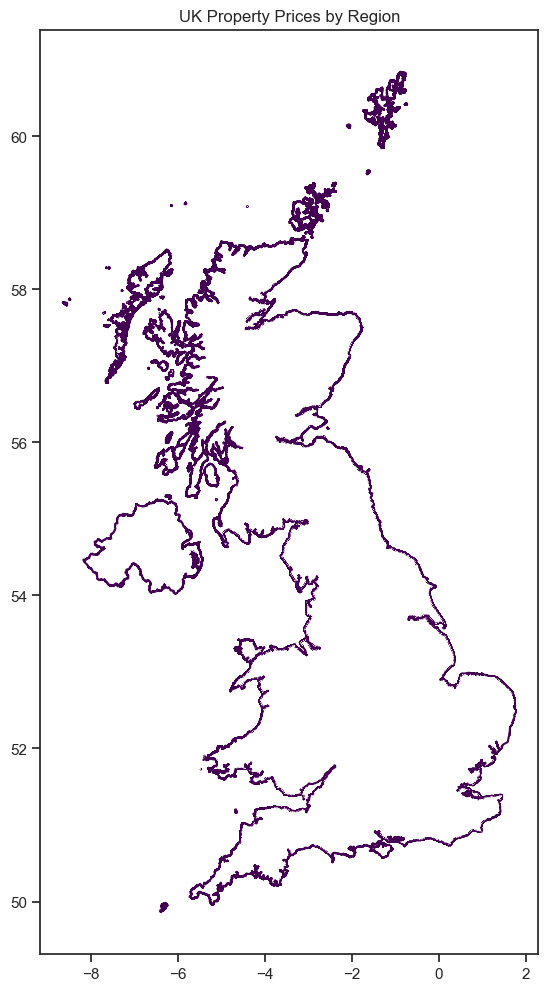

In [89]:
gb = gpd.read_file('../_00_Informacion/UK shapefile/gadm41_GBR_0.shp')
gb['geometry'] = gb.geometry.boundary

# Plot a choropleth map using GeoPandas
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
gb.plot(column='GID_0', ax=ax, cmap='viridis')

plt.title('UK Property Prices by Region')
plt.show()

Ahora, usando esta información, podemos detectar si un distrito es costero o no:

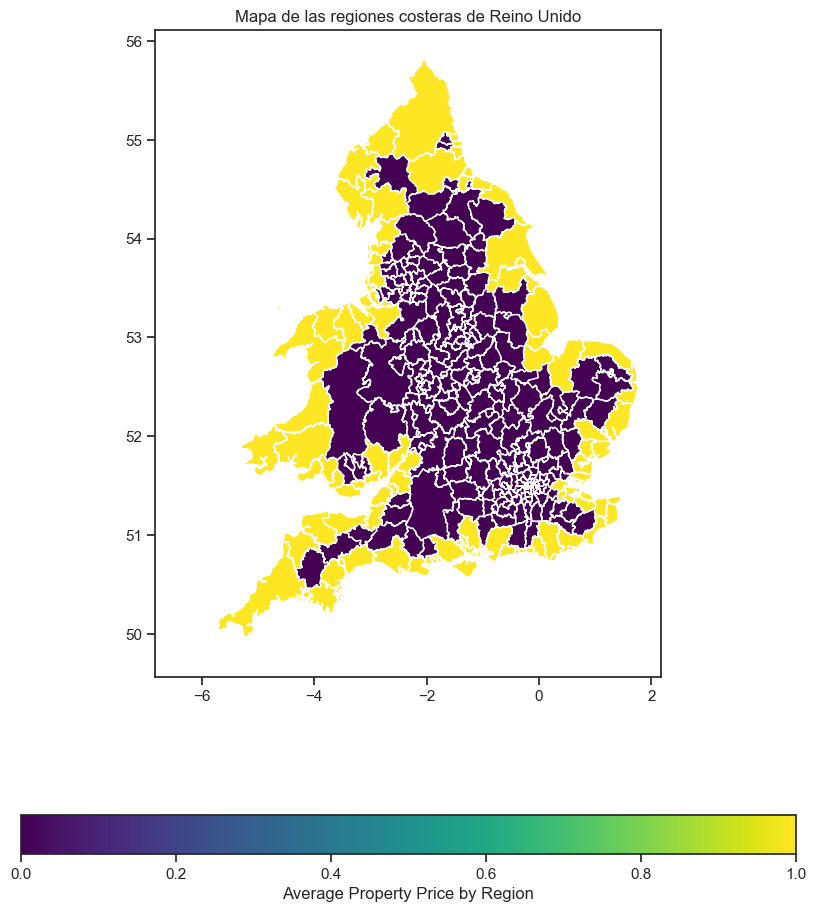

In [90]:
# Solo es necesario ejecutarlo una vez, así que se deja comentado

# gb_sindexes = gb.sindex
# bounds = uk_geo.bounds

# # Around 8 minutes
# intersections = uk_geo.geometry.apply(lambda x: gb.geometry.intersects(x).any())
# uk_geo.loc[:, ["District", "is_coastal"]].to_csv(path_or_buf="../output/coastal_districts.csv")
# uk_geo["is_coastal"] = intersections.astype("int")
# uk_geo.head()

if "is_coastal" not in uk_geo.columns:
    uk_geo = pd.merge(
    left=uk_geo, 
    right=pd.read_csv("../output/coastal_districts.csv").\
        loc[:, ["District", "is_coastal"]], 
    how="left", on="District")

# Plot results
# Plot a choropleth map using GeoPandas
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
uk_geo.plot(column='is_coastal', ax=ax, legend=True, 
            legend_kwds={'label': "Average Property Price by Region",
                         'orientation': "horizontal"}, 
            cmap='viridis')

plt.title('Mapa de las regiones costeras de Reino Unido')
plt.show()

Por otro lado, podemos detectar también, mediante las conexiones entre los polígonos que se dibujan en el mapa, qué distritos son islas:

In [91]:
# !pip install libpysal
from libpysal.weights import Queen

w = Queen.from_dataframe(df=uk_geo, use_index=False)
w.transform = 'R' 
# B = Binary
# R = Row-standardization (global sum = n)
# D = Double-standardization (global sum = 1)
# V = Variance stabilizing
# O = Restore original transformation (from instantiation)

indeces_islands = [1 if (value == []) else 0 for value in w.neighbors.values()] 
uk_geo["is_isle"] = indeces_islands

uk_geo.head()

('WARNING: ', 112, ' is an island (no neighbors)')
('WARNING: ', 113, ' is an island (no neighbors)')
('WARNING: ', 369, ' is an island (no neighbors)')
('WARNING: ', 371, ' is an island (no neighbors)')
('WARNING: ', 375, ' is an island (no neighbors)')


c:\Users\domin\anaconda3\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 5 islands with ids: 112, 113, 369, 371, 375.
  W.__init__(self, neighbors, ids=ids, **kw)


,District,geometry,Price,Property.Type,Duration,Year,month,day,q1,q3,...,BandB,BandC,BandD,BandE,BandF,BandG,job_density,density_population_hectare,is_coastal,is_isle
0,bath and north east somerset,"POLYGON ((-2.41998 51.29636, -2.41985 51.29626...",249863.270664,1.259128,0.253423,2007.373859,6.904665,16.807302,105188.715581,230482.547129,...,16.100000,26.500000,38.700000,15.000000,2.60000,0.600000,0.890000,5.1,0.0,0
1,bedford,"POLYGON ((-0.5112 52.0966, -0.51163 52.09579, ...",187964.181029,1.258782,0.142218,2007.397185,6.891330,17.330088,104912.241481,229394.297625,...,21.600000,34.100000,31.200000,10.800000,1.60000,0.400000,0.820000,3.3,0.0,0
2,blackburn with darwen,"POLYGON ((-2.45543 53.77399, -2.45488 53.77373...",94908.961203,0.692965,0.360683,2007.175794,6.871171,16.545573,104834.712642,228324.472805,...,9.200000,27.600000,42.400000,16.800000,3.00000,0.800000,0.810000,10.8,0.0,0
3,blackpool,"POLYGON ((-3.03989 53.77958, -3.04253 53.7791,...",89521.295231,0.849253,0.141922,2005.689110,6.751032,16.498363,96621.208648,210913.198790,...,3.800000,22.800000,47.400000,21.400000,3.40000,1.300000,0.830000,40.7,1.0,0
4,bournemouth,"POLYGON ((-1.84116 50.71964, -1.84116 50.71958...",171387.157665,2.247030,0.501021,2005.452765,6.801875,16.876114,95416.007934,207394.957220,...,14.186103,30.255891,38.450151,13.375529,2.62145,0.776737,1.153373,39.7,1.0,0


In [92]:
# Save results
with open('../output/uk_geo.pkl', 'wb') as f:
            pickle.dump(uk_geo, f)

Finalmente, unimos los resultados con los datos de entrenamiento y test:

In [93]:
if "is_coastal" not in train_df.columns:
    train_df = pd.merge(
        left = train_df, 
        right=uk_geo.loc[:, ["District", "is_coastal", "is_isle"]],
        how="left", on="District"
    )
train_df.head()

,Price,date,Property.Type,Duration,Town.City,District,County,Year,month,day,...,BandD,BandE,BandF,BandG,job_density,density_population_hectare,year_to_year_change,price_compare_london,is_coastal,is_isle
0,300000,1995-01-01,3,1,london,merton,greater london,1995,1,1,...,42.600000,11.700000,1.20000,0.400000,0.6200,53.100000,0.067748,3.041568,0.0,0.0
1,70500,1995-01-01,1,0,horsham,horsham,west sussex,1995,1,1,...,33.500000,12.100000,2.90000,0.700000,0.8300,2.500000,0.067748,0.714769,0.0,0.0
2,35000,1995-01-01,0,0,dewsbury,kirklees,west yorkshire,1995,1,1,...,44.800000,15.800000,2.20000,0.700000,0.6600,10.300000,0.067748,0.354850,0.0,0.0
3,41000,1995-01-01,1,0,gloucester,gloucester,gloucestershire,1995,1,1,...,40.000000,11.400000,1.40000,0.500000,0.8600,30.000000,0.067748,0.415681,0.0,0.0
4,125000,1995-01-01,2,0,macclesfield,macclesfield,cheshire,1995,1,1,...,38.856002,13.168595,2.32766,0.665925,0.9032,19.941368,0.067748,1.267320,NaN,NaN


Los datos faltantes los imputaremos como 0, es decir, que no son ni distritos costeros ni islas:

In [94]:
train_df.loc[:, ["is_coastal", "is_isle"]] = train_df.loc[:, ["is_coastal", "is_isle"]].fillna(0)

Hacemos lo mismo en test:

In [95]:
if "is_coastal" not in test_df.columns:
    test_df = pd.merge(
        left = test_df, 
        right=uk_geo.loc[:, ["District", "is_coastal", "is_isle"]],
        how="left", on="District"
    )
test_df.loc[:, ["is_coastal", "is_isle"]] = test_df.loc[:, ["is_coastal", "is_isle"]].fillna(0)

### Modelo de clúster con las posiciones de los pueblos y ciudades

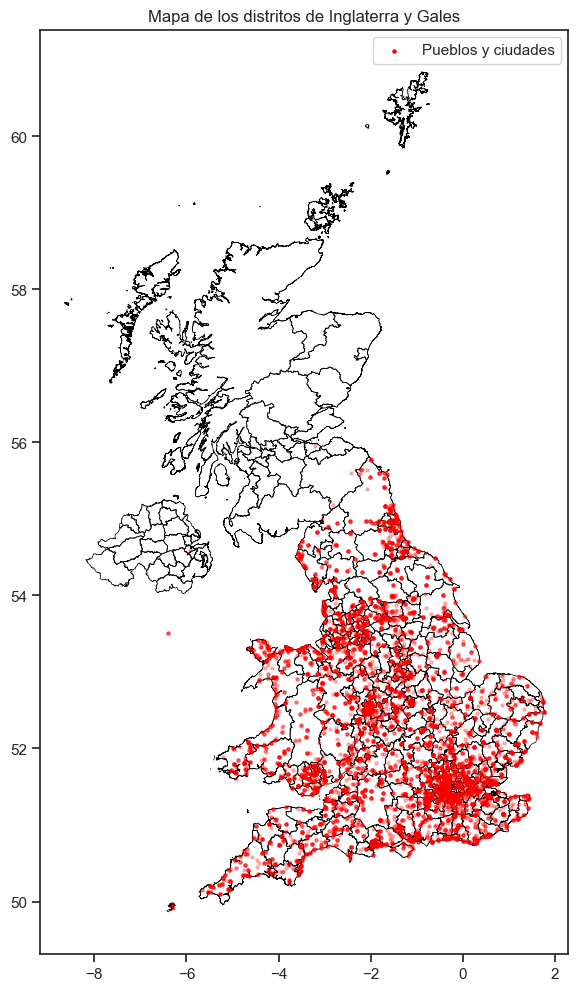

In [96]:
# https://gis.stackexchange.com/questions/241612/change-marker-size-in-plot-with-geopandas
# https://matplotlib.org/stable/users/explain/axes/legend_guide.html

fig, ax = plt.subplots(1, 1, figsize=(10, 12))
uk_geo.plot(ax=ax, linewidth=0.5, facecolor="none", edgecolor="black")

size = 5
town_city_coords.plot(ax=ax, color="red", markersize=size, alpha=0.25)

red_dots = plt.scatter(x=[], y=[], s=size, color="red", label="Pueblos y ciudades")
ax.legend(handles=[red_dots])

plt.title('Mapa de los distritos de Inglaterra y Gales')
plt.show()

Hagámos un grid search del número óptimo de pueblos y ciudades por clúster:

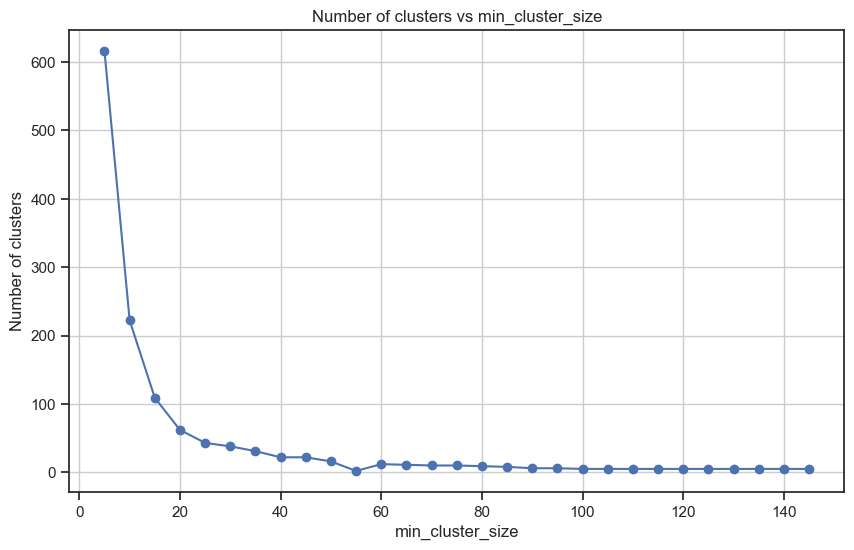

In [97]:
from hdbscan import HDBSCAN

# Set a range of min_cluster_size values to explore
min_cluster_sizes = np.arange(5, 150, 5)

# List to store the number of clusters for each min_cluster_size
num_clusters = []

for min_cluster_size in min_cluster_sizes:
    # Perform HDBSCAN clustering
    clusterer = HDBSCAN(min_cluster_size=min_cluster_size)
    cluster_labels = clusterer.fit_predict(town_city_coords[["Latitude", "Longitude"]])
    
    # Count the number of unique clusters (ignoring noise points labeled as -1)
    num_clusters.append(len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0))

# Plot the number of clusters as a function of min_cluster_size
plt.figure(figsize=(10, 6))
plt.plot(min_cluster_sizes, num_clusters, marker='o')
plt.title('Number of clusters vs min_cluster_size')
plt.xlabel('min_cluster_size')
plt.ylabel('Number of clusters')
plt.grid(True)
plt.show()


Tomamos el 30, ya que se estabiliza el número de clústers. Es decir, no es necesario incrementar más el valor, porque no se obtiene una variación significativa.

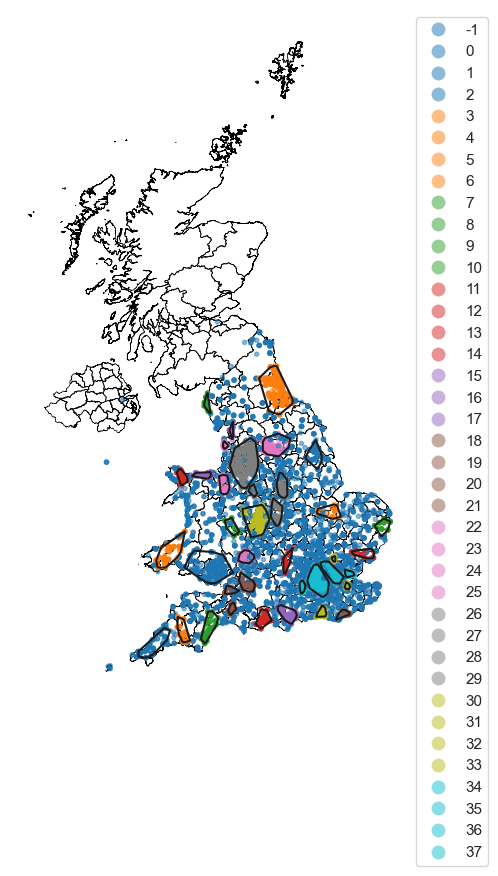

In [98]:
labels = HDBSCAN(min_cluster_size=30).fit(town_city_coords[["Longitude", "Latitude"]]).labels_
hulls = town_city_coords[["geometry"]].dissolve(by=labels).convex_hull

# Set up figure and axis
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
uk_geo.plot(ax=ax, linewidth=0.5, facecolor="none", edgecolor="black")

# Plot individual Town/City locations
town_city_coords.plot(
    # Color by cluster label
    column=labels,
    # Consider label as categorical
    categorical=True,
    # Add 50% of transparency
    alpha=0.5,
    # Include legend
    legend=True,
    # Draw on axis `ax`
    ax=ax,
    # Use circle as marker
    marker=".",
    # Position legend outside the map
    legend_kwds={"bbox_to_anchor": (1, 1)},
)
# Plot convex hull polygons for each cluster label
# except that for -1 (observations classified as noise)
hulls[hulls.index != -1].boundary.plot(color="k", ax=ax)

# Remove axes
ax.set_axis_off()

plt.savefig('cluster_pueblos_ciudades.png', bbox_inches='tight')
plt.show()

Añadimos la información a los datos:

In [99]:
town_city_coords["spatial_cluster"] = labels

if "spatial_cluster" not in train_df.columns:
    train_df = pd.merge(left=train_df, 
                        right=town_city_coords.loc[:, ["County", "District", "Town.City", "spatial_cluster"]], 
                        on=["County", "District", "Town.City"], 
                        how="left")
    test_df = pd.merge(left=test_df, 
                       right=town_city_coords.loc[:, ["County", "District", "Town.City", "spatial_cluster"]], 
                       on=["County", "District", "Town.City"], 
                       how="left")
train_df.head()

,Price,date,Property.Type,Duration,Town.City,District,County,Year,month,day,...,BandE,BandF,BandG,job_density,density_population_hectare,year_to_year_change,price_compare_london,is_coastal,is_isle,spatial_cluster
0,300000,1995-01-01,3,1,london,merton,greater london,1995,1,1,...,11.700000,1.20000,0.400000,0.6200,53.100000,0.067748,3.041568,0.0,0.0,35
1,70500,1995-01-01,1,0,horsham,horsham,west sussex,1995,1,1,...,12.100000,2.90000,0.700000,0.8300,2.500000,0.067748,0.714769,0.0,0.0,-1
2,35000,1995-01-01,0,0,dewsbury,kirklees,west yorkshire,1995,1,1,...,15.800000,2.20000,0.700000,0.6600,10.300000,0.067748,0.354850,0.0,0.0,23
3,41000,1995-01-01,1,0,gloucester,gloucester,gloucestershire,1995,1,1,...,11.400000,1.40000,0.500000,0.8600,30.000000,0.067748,0.415681,0.0,0.0,-1
4,125000,1995-01-01,2,0,macclesfield,macclesfield,cheshire,1995,1,1,...,13.168595,2.32766,0.665925,0.9032,19.941368,0.067748,1.267320,0.0,0.0,-1


### Distancia a Ciudad de Londres

Hemos visto en el análisis exploratorio que los precios decrecen conforme nos alejamos de Londres.

In [100]:
town_city_coords.head()

,address,Latitude,Longitude,Town.City,District,County,geometry,spatial_cluster
0,"devon, plymouth, plymouth",50.384416,-4.078946,plymouth,plymouth,devon,POINT (-4.07895 50.38442),4
1,"avon, bristol, bristol",51.449620,-2.557939,bristol,bristol,avon,POINT (-2.55794 51.44962),20
2,"humberside, the east yorkshire borough of beve...",53.723159,-0.434931,hessle,the east yorkshire borough of beverley,humberside,POINT (-0.43493 53.72316),0
3,"west yorkshire, wakefield, wakefield",53.683046,-1.496800,wakefield,wakefield,west yorkshire,POINT (-1.4968 53.68305),23
4,"northamptonshire, corby, corby",52.488849,-0.688383,corby,corby,northamptonshire,POINT (-0.68838 52.48885),-1


In [101]:
import math
town_city_coords["Latitude"] = town_city_coords["Latitude"] * math.pi / 180
town_city_coords["Longitude"] = town_city_coords["Longitude"] * math.pi / 180
town_city_coords.head()

,address,Latitude,Longitude,Town.City,District,County,geometry,spatial_cluster
0,"devon, plymouth, plymouth",0.879374,-0.071191,plymouth,plymouth,devon,POINT (-4.07895 50.38442),4
1,"avon, bristol, bristol",0.897965,-0.044644,bristol,bristol,avon,POINT (-2.55794 51.44962),20
2,"humberside, the east yorkshire borough of beve...",0.937646,-0.007591,hessle,the east yorkshire borough of beverley,humberside,POINT (-0.43493 53.72316),0
3,"west yorkshire, wakefield, wakefield",0.936946,-0.026124,wakefield,wakefield,west yorkshire,POINT (-1.4968 53.68305),23
4,"northamptonshire, corby, corby",0.916103,-0.012015,corby,corby,northamptonshire,POINT (-0.68838 52.48885),-1


In [102]:

(lat_ref, long_ref) = town_city_coords.\
    loc[(town_city_coords["District"] == "city of london"), ["Latitude", "Longitude"]].values[0]

def distance(lat, long, lat_ref=lat_ref, long_ref=long_ref):
    R = 6371 # km, Earth's radius
    diff_lat = lat_ref - lat
    diff_long = long_ref - long

    a = math.sin(diff_lat/2) ** 2 + \
        math.cos(lat) * math.cos(lat_ref) * math.sin(diff_long/2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c

town_city_coords["distance_to_london"] = town_city_coords.apply(lambda x: distance(x["Latitude"], x["Longitude"]), axis=1)
town_city_coords.head()

,address,Latitude,Longitude,Town.City,District,County,geometry,spatial_cluster,distance_to_london
0,"devon, plymouth, plymouth",0.879374,-0.071191,plymouth,plymouth,devon,POINT (-4.07895 50.38442),4,306.991842
1,"avon, bristol, bristol",0.897965,-0.044644,bristol,bristol,avon,POINT (-2.55794 51.44962),20,171.865049
2,"humberside, the east yorkshire borough of beve...",0.937646,-0.007591,hessle,the east yorkshire borough of beverley,humberside,POINT (-0.43493 53.72316),0,247.062019
3,"west yorkshire, wakefield, wakefield",0.936946,-0.026124,wakefield,wakefield,west yorkshire,POINT (-1.4968 53.68305),23,259.733559
4,"northamptonshire, corby, corby",0.916103,-0.012015,corby,corby,northamptonshire,POINT (-0.68838 52.48885),-1,116.393639


In [103]:
# Save results
with open('../output/town_city_coords_final.pkl', 'wb') as f:
            pickle.dump(town_city_coords, f)

In [104]:
def create_distance_to_london(df):
    temp = pd.merge(
        left=df,
        right=town_city_coords.loc[:, ["Town.City", "District", 
                                       "County", "distance_to_london"]],
        how="left", on=["Town.City", "District", "County"]
    )
    return temp

train_df = create_distance_to_london(train_df)
test_df = create_distance_to_london(test_df)

### Variables a partir de un modelo espacial

Vamos a crear un modelo OLS (mínimos cuadrados ordinarios) por distrito para evaluar el efecto que tiene cada uno a la estimación de Price:

In [105]:
# Free space
del census_df, hierarchy_geo, price, data_geo, fig, gb


In [106]:
import statsmodels.formula.api as sm

sample = train_df.\
    groupby('District', group_keys=False)[train_df.columns].\
        apply(lambda x: x.sample(min(len(x), 10))).\
            rename(columns={"Property.Type": "Property_Type"})

temp = [v for v in sample.select_dtypes("number").columns 
        if v not in ["Price", "Price_boxcox"]]
f = (
    "Price_boxcox ~ ("
    + " + ".join(temp)
    + ") : District"
)
m = sm.ols(f, data=sample).fit()

In [107]:

# Store variable names for all the spatial fixed effects
sfe_names = [i for i in m.params.index if "District[" in i]
# Create table
pd.DataFrame(
    {
        "Coef.": m.params[sfe_names],
        "Std. Error": m.bse[sfe_names],
        "P-Value": m.pvalues[sfe_names],
    }
)

,Coef.,Std. Error,P-Value
Property_Type:District[aberconwy],3.982445e-01,7.247982e-02,5.774415e-04
Property_Type:District[adur],-1.065352e-01,3.935634e-02,2.678469e-02
Property_Type:District[allerdale],-1.306138e-01,3.323108e-02,4.353794e-03
Property_Type:District[alnwick],3.130108e-01,5.356280e-02,3.854739e-04
Property_Type:District[alyn and deeside],-9.974750e-01,6.999595e-02,5.730028e-07
...,...,...,...
distance_to_london:District[wycombe],1.201203e-01,1.638556e-02,8.142551e-05
distance_to_london:District[wyre],1.358918e-01,1.721508e-02,4.807322e-05
distance_to_london:District[wyre forest],-2.174186e-01,8.480726e-02,3.345493e-02
distance_to_london:District[ynys mon-isle of anglesey],-1.835219e-01,1.327746e+00,8.934818e-01


In [108]:
# Extract the effect of Districts (coefficent)
district_effects = m.params.filter(like="District")

# Create a sequence with the variable names without
# `District[` and `]`
# stripped = district_effects.index.str.strip(to_strip="District[").str.strip(to_strip="]")
temp = district_effects.reset_index()
stripped = temp["index"].str.split(pat="[").apply(lambda x: x[-1].split(sep="]")[0])
# Reindex the district_effects Series on clean names
district_effects.index = stripped
# Convert Series to DataFrame
district_effects = district_effects.to_frame("fixed_effect").reset_index()
# Print top of table
district_effects.head()

,index,fixed_effect
0,aberconwy,0.398244
1,adur,-0.106535
2,allerdale,-0.130614
3,alnwick,0.313011
4,alyn and deeside,-0.997475


In [109]:
# Save results
with open('../output/district_effects.pkl', 'wb') as f:
            pickle.dump(district_effects, f)

In [110]:
# Free space
del m 

In [111]:
train_df.loc[:, "fixed_effect"] = pd.merge(left=train_df.loc[:, "District"], right=district_effects,
            left_on="District", right_on="index",
            how="left").loc[:, "fixed_effect"]

In [112]:
with open('../output/district_effects.pkl', 'rb') as f:
    district_effects = pickle.load(f)

if "district_effect" not in train_df.columns:
    train_df["fixed_effect"] = pd.merge(
        left=train_df.loc[:, "District"], 
        right=district_effects,
        left_on="District", right_on="index",
        how="left").\
            rename(columns={"fixed_effect": "district_effects"}).\
                loc[:, "district_effects"]


    test_df["fixed_effect"] = pd.merge(
        left=test_df.loc[:, "District"], 
        right=district_effects,
        left_on="District", right_on="index",
        how="left").\
            rename(columns={"fixed_effect": "district_effects"}).\
                loc[:, "district_effects"]

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2509428 entries, 0 to 2509427
Data columns (total 41 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   Price                       int64         
 1   date                        datetime64[ns]
 2   Property.Type               int64         
 3   Duration                    int64         
 4   Town.City                   object        
 5   District                    object        
 6   County                      object        
 7   Year                        int64         
 8   month                       int64         
 9   day                         int64         
 10  date2                       object        
 11  q1                          float64       
 12  q3                          float64       
 13  is_top_outlier              int32         
 14  is_bottom_outlier           int32         
 15  mean_price                  float64       
 16  First_hand        

## Modificación de variables

De manera análoga a como transformamos la variable Price, las variables que vienen de ella también deberían ser modificadas:

In [113]:
def variable_modification(df):
    x_names = ["price_compare_london",
               "q1", "q3", "mean_price",
               "year_to_year_change"]
    
    for x in [v for v in x_names if "log_"+v not in df.columns]:
        newname = "log_"+x
        df[newname] = np.log(np.abs(df[x]) + 0.01)

variable_modification(train_df)
variable_modification(test_df)
display(train_df.head())
display(test_df.head())

,Price,date,Property.Type,Duration,Town.City,District,County,Year,month,day,...,is_coastal,is_isle,spatial_cluster,distance_to_london,fixed_effect,log_price_compare_london,log_q1,log_q3,log_mean_price,log_year_to_year_change
0,300000,1995-01-01,3,1,london,merton,greater london,1995,1,1,...,0.0,0.0,35,14.767341,-0.028847,1.115656,10.760559,11.875831,11.630391,-2.554285
1,70500,1995-01-01,1,0,horsham,horsham,west sussex,1995,1,1,...,0.0,0.0,-1,52.332986,-0.217594,-0.321903,10.760559,11.875831,11.630391,-2.554285
2,35000,1995-01-01,0,0,dewsbury,kirklees,west yorkshire,1995,1,1,...,0.0,0.0,23,263.987139,0.048692,-1.008270,10.760559,11.875831,11.630391,-2.554285
3,41000,1995-01-01,1,0,gloucester,gloucester,gloucestershire,1995,1,1,...,0.0,0.0,-1,154.010206,-0.024672,-0.854065,10.760559,11.875831,11.630391,-2.554285
4,125000,1995-01-01,2,0,macclesfield,macclesfield,cheshire,1995,1,1,...,0.0,0.0,-1,238.724517,0.015352,0.244764,10.760559,11.875831,11.630391,-2.554285


,Price,date,Property.Type,Duration,Town.City,District,County,Year,month,day,...,density_population_hectare,year_to_year_change,price_compare_london,is_coastal,is_isle,spatial_cluster,distance_to_london,fixed_effect,log_price_compare_london,log_year_to_year_change
0,234000,2021-01-01,2,1,liverpool,knowsley,merseyside,2021,1,1,...,16.9,-3.398167,0.267224,0.0,0.0,27,281.418586,0.185357,-1.282930,1.226175
1,255000,2021-01-01,3,1,st ives,cornwall,cornwall,2021,1,1,...,1.5,-3.398167,0.377871,1.0,0.0,2,405.477039,0.167724,-0.947081,1.226175
2,360000,2021-01-01,3,1,west wickham,bromley,greater london,2021,1,1,...,20.6,-3.398167,0.748934,0.0,0.0,35,15.752726,0.376565,-0.275841,1.226175
3,590000,2021-01-01,1,0,orpington,bromley,greater london,2021,1,1,...,20.6,-3.398167,0.748934,0.0,0.0,-1,19.232435,0.068507,-0.275841,1.226175
4,297500,2021-01-01,1,0,atherstone,north warwickshire,warwickshire,2021,1,1,...,2.2,-3.398167,0.383040,0.0,0.0,29,155.162883,0.021452,-0.933843,1.226175


In [114]:
test_df.isna().sum()[test_df.isna().sum() > 0]

Series([], dtype: int64)

In [115]:
test_df.loc[test_df["price_compare_london"].isnull(), "price_compare_london"] = np.mean(test_df["price_compare_london"])
test_df.loc[test_df["log_price_compare_london"].isnull(), "log_price_compare_london"] =  np.mean(test_df["log_price_compare_london"])

test_df.isna().sum()[test_df.isna().sum() > 0]

Series([], dtype: int64)

### Escalado

In [116]:
# Save results
with open('../output/train_df_pre_escalado.pkl', 'wb') as f:
            pickle.dump(train_df, f)

In [117]:
display(train_df.describe())
display(test_df.describe())

,Price,Property.Type,Duration,Year,month,day,q1,q3,is_top_outlier,is_bottom_outlier,...,is_coastal,is_isle,spatial_cluster,distance_to_london,fixed_effect,log_price_compare_london,log_q1,log_q3,log_mean_price,log_year_to_year_change
count,2.509428e+06,2.509428e+06,2.509428e+06,2.509428e+06,2.509428e+06,2.509428e+06,2.509428e+06,2.509428e+06,2.509428e+06,2.509428e+06,...,2.509428e+06,2.509428e+06,2.509428e+06,2.509428e+06,2.509428e+06,2.509428e+06,2.509428e+06,2.509428e+06,2.509428e+06,2.509428e+06
mean,1.886003e+05,1.294063e+00,2.337441e-01,2.006632e+03,6.827684e+00,1.707371e+01,1.013235e+05,2.210133e+05,6.181927e-02,3.068428e-05,...,2.668520e-01,3.264489e-03,1.085062e+01,1.619395e+02,2.955877e-02,-1.010417e+00,1.142296e+01,1.220086e+01,1.204122e+01,-1.352471e+00
std,2.245794e+05,1.084238e+00,4.232114e-01,7.344136e+00,3.336744e+00,9.035167e+00,4.177242e+04,9.353802e+04,2.408271e-01,5.539256e-03,...,4.423145e-01,5.704238e-02,1.431310e+01,1.099488e+02,1.008563e+00,6.831147e-01,4.787057e-01,4.823176e-01,4.840199e-01,1.343641e+00
min,1.000000e+02,0.000000e+00,0.000000e+00,1.995000e+03,1.000000e+00,1.000000e+00,7.500000e+02,7.500000e+02,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,-2.994984e+01,-4.565658e+00,6.620087e+00,6.620087e+00,6.620087e+00,-4.605170e+00
25%,8.000000e+04,0.000000e+00,0.000000e+00,2.001000e+03,4.000000e+00,9.000000e+00,5.600000e+04,1.358375e+05,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,-1.000000e+00,6.219920e+01,-3.103132e-07,-1.452941e+00,1.093311e+01,1.181921e+01,1.163594e+01,-2.246974e+00
50%,1.400000e+05,1.000000e+00,0.000000e+00,2.006000e+03,7.000000e+00,1.800000e+01,1.157812e+05,2.300000e+05,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,1.000000e+00,1.595770e+02,0.000000e+00,-1.012906e+00,1.165946e+01,1.234583e+01,1.218843e+01,-1.395018e+00
75%,2.300000e+05,2.000000e+00,0.000000e+00,2.013000e+03,1.000000e+01,2.500000e+01,1.320000e+05,2.897500e+05,0.000000e+00,0.000000e+00,...,1.000000e+00,0.000000e+00,2.700000e+01,2.581435e+02,1.807282e-05,-5.790364e-01,1.179056e+01,1.257677e+01,1.243537e+01,-6.029702e-01
max,3.000000e+07,3.000000e+00,1.000000e+00,2.020000e+03,1.200000e+01,3.100000e+01,3.142000e+06,4.689999e+06,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,3.700000e+01,5.198819e+02,1.352618e+02,4.130206e+00,1.496037e+01,1.536094e+01,1.497239e+01,8.861885e+00


,Price,Property.Type,Duration,Year,month,day,log_q1,log_q3,log_mean_price,q1,...,density_population_hectare,year_to_year_change,price_compare_london,is_coastal,is_isle,spatial_cluster,distance_to_london,fixed_effect,log_price_compare_london,log_year_to_year_change
count,1.885840e+05,188584.000000,188584.000000,188584.000000,188584.000000,188584.000000,188584.000000,188584.000000,188584.000000,188584.000000,...,188584.000000,188584.000000,188584.000000,188584.000000,188584.000000,188584.000000,188584.000000,1.885840e+05,188584.000000,188584.000000
mean,3.556992e+05,1.310912,0.216572,2021.508203,6.063409,17.490126,11.910708,12.623884,12.484486,148947.102259,...,17.696494,-2.396245,0.458610,0.268273,0.003351,10.457716,167.920030,2.419900e-02,-0.836667,0.694019
std,3.688959e+05,1.057916,0.411909,0.605627,3.383878,8.957610,0.034812,0.072008,0.050297,5618.510690,...,23.167809,1.221324,0.222303,0.443062,0.057793,14.094925,109.465256,1.021639e+00,0.374063,0.654897
min,1.000000e+00,0.000000,0.000000,2021.000000,1.000000,1.000000,11.881357,12.431967,12.376588,144546.561872,...,0.200000,-3.398167,0.182655,0.000000,0.000000,-1.000000,0.000000,-2.994984e+01,-1.646857,-0.122413
25%,1.800000e+05,0.000000,0.000000,2021.000000,3.000000,10.000000,11.902934,12.566550,12.454307,147699.364476,...,2.900000,-3.398167,0.322083,0.000000,0.000000,-1.000000,73.186179,-4.306005e-07,-1.102369,-0.122413
50%,2.765000e+05,1.000000,0.000000,2021.000000,6.000000,18.000000,11.903440,12.625130,12.499247,147774.083864,...,10.300000,-3.398167,0.392506,0.000000,0.000000,1.000000,163.871882,0.000000e+00,-0.910046,1.226175
75%,4.200000e+05,2.000000,0.000000,2022.000000,9.000000,26.000000,11.911441,12.660458,12.517974,148961.170354,...,21.300000,-0.874783,0.525226,1.000000,0.000000,27.000000,261.517649,2.015520e-05,-0.625066,1.226175
max,2.400000e+07,3.000000,1.000000,2023.000000,12.000000,31.000000,12.100512,12.759628,12.562314,179963.905984,...,138.700000,-0.874783,2.487937,1.000000,1.000000,37.000000,490.056043,1.352618e+02,0.915465,1.226175


Ambas tienen una media y una desviación estándas similar, por lo que tiene sentido aplicarles el mismo escalado. Esto además era necesario, ya que no tiene sentido hacer un escalado diferente para test, porque se obtendrían resultados erróneos en el modelo.

También será necesario ordenar las columnas de la misma forma que están en train:

In [118]:
test_df = test_df.loc[:, [v for v in train_df.columns if v != "date2"]]
display(train_df.head(1))
display(test_df.head(1))

,Price,date,Property.Type,Duration,Town.City,District,County,Year,month,day,...,is_coastal,is_isle,spatial_cluster,distance_to_london,fixed_effect,log_price_compare_london,log_q1,log_q3,log_mean_price,log_year_to_year_change
0,300000,1995-01-01,3,1,london,merton,greater london,1995,1,1,...,0.0,0.0,35,14.767341,-0.028847,1.115656,10.760559,11.875831,11.630391,-2.554285


,Price,date,Property.Type,Duration,Town.City,District,County,Year,month,day,...,is_coastal,is_isle,spatial_cluster,distance_to_london,fixed_effect,log_price_compare_london,log_q1,log_q3,log_mean_price,log_year_to_year_change
0,234000,2021-01-01,2,1,liverpool,knowsley,merseyside,2021,1,1,...,0.0,0.0,27,281.418586,0.185357,-1.28293,11.928336,12.759628,12.517974,1.226175


In [119]:
train_df.columns

Index(['Price', 'date', 'Property.Type', 'Duration', 'Town.City', 'District',
       'County', 'Year', 'month', 'day', 'date2', 'q1', 'q3', 'is_top_outlier',
       'is_bottom_outlier', 'mean_price', 'First_hand',
       'Paid_Additional_Price', 'org_property_type', 'org_duration',
       'Price_boxcox', 'total_people', 'people_working', 'people_studying',
       'total_houses', 'BandA', 'BandB', 'BandC', 'BandD', 'BandE', 'BandF',
       'BandG', 'job_density', 'density_population_hectare',
       'year_to_year_change', 'price_compare_london', 'is_coastal', 'is_isle',
       'spatial_cluster', 'distance_to_london', 'fixed_effect',
       'log_price_compare_london', 'log_q1', 'log_q3', 'log_mean_price',
       'log_year_to_year_change'],
      dtype='object')

In [120]:
numeric_columns = train_df.select_dtypes(include=['number']).columns
# to_scale = ["mean_price", "Price_boxcox", "total_people", 
#             "year_to_year_change", "price_compare_london", "distance_to_london",
#             "log_price_compare_london", "log_q1", "log_q3", "log_mean_price",
#             "log_year_to_year_change", "q1", "q3", "mean_price", "fixed_effect",
#             "BandA", "BandB", "BandC", "BandD", "BandE", "BandF", "job_density"]

not_to_scale = ("Year", "month", "day", 
                "org_mean_price", "org_price_boxcox",
                'Price', 'Paid_Additional_Price', 'people_working', 
                'people_studying', 'total_houses', 'BandG',
                'Property.Type', 'Duration', 
                'is_top_outlier', 'is_bottom_outlier', "First_hand")
to_scale = [v for v in numeric_columns if v not in not_to_scale]

Entrenamos el escalador y transformamos los conjuntos de datos:

In [121]:
from sklearn.preprocessing import StandardScaler

# Standardize the independent variables
scaler = StandardScaler()

train_df["org_mean_price"] = train_df["mean_price"]
train_df["org_price"] = train_df["Price"]
train_df[to_scale] = scaler.fit_transform(train_df[to_scale])
joblib.dump(scaler, "../output/scaler.gz") # <-- Save scaler to use in pipeline
display(train_df.describe())

,Price,Property.Type,Duration,Year,month,day,q1,q3,is_top_outlier,is_bottom_outlier,...,spatial_cluster,distance_to_london,fixed_effect,log_price_compare_london,log_q1,log_q3,log_mean_price,log_year_to_year_change,org_mean_price,org_price
count,2.509428e+06,2.509428e+06,2.509428e+06,2.509428e+06,2.509428e+06,2.509428e+06,2.509428e+06,2.509428e+06,2.509428e+06,2.509428e+06,...,2.509428e+06,2.509428e+06,2.509428e+06,2.509428e+06,2.509428e+06,2.509428e+06,2.509428e+06,2.509428e+06,2.509428e+06,2.509428e+06
mean,1.886003e+05,1.294063e+00,2.337441e-01,2.006632e+03,6.827684e+00,1.707371e+01,3.004554e-16,2.247073e-17,6.181927e-02,3.068428e-05,...,3.438565e-17,-7.801329e-16,9.356845e-18,8.740026e-16,1.521341e-14,5.270835e-15,-9.385696e-15,4.593814e-17,1.886003e+05,1.886003e+05
std,2.245794e+05,1.084238e+00,4.232114e-01,7.344136e+00,3.336744e+00,9.035167e+00,1.000000e+00,1.000000e+00,2.408271e-01,5.539256e-03,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,8.010692e+04,2.245794e+05
min,1.000000e+02,0.000000e+00,0.000000e+00,1.995000e+03,1.000000e+00,1.000000e+00,-2.407654e+00,-2.354800e+00,0.000000e+00,0.000000e+00,...,-8.279566e-01,-1.472863e+00,-2.972487e+01,-5.204458e+00,-1.003303e+01,-1.157074e+01,-1.120023e+01,-2.420810e+00,7.500000e+02,1.000000e+02
25%,8.000000e+04,0.000000e+00,0.000000e+00,2.001000e+03,4.000000e+00,9.000000e+00,-1.085010e+00,-9.106006e-01,0.000000e+00,0.000000e+00,...,-8.279566e-01,-9.071521e-01,-2.930811e-02,-6.478026e-01,-1.023277e+00,-7.912693e-01,-8.373093e-01,-6.657303e-01,1.130905e+05,8.000000e+04
50%,1.400000e+05,1.000000e+00,0.000000e+00,2.006000e+03,7.000000e+00,1.800000e+01,3.461079e-01,9.607580e-02,0.000000e+00,0.000000e+00,...,-6.882244e-01,-2.148693e-02,-2.930780e-02,-3.642869e-03,4.940451e-01,3.005840e-01,3.041431e-01,-3.166517e-02,1.965023e+05,1.400000e+05
75%,2.300000e+05,2.000000e+00,0.000000e+00,2.013000e+03,1.000000e+01,2.500000e+01,7.343726e-01,7.348536e-01,0.000000e+00,0.000000e+00,...,1.128294e+00,8.749889e-01,-2.928988e-02,6.314912e-01,7.679071e-01,7.793955e-01,8.143368e-01,5.578135e-01,2.515440e+05,2.300000e+05
max,3.000000e+07,3.000000e+00,1.000000e+00,2.020000e+03,1.200000e+01,3.100000e+01,7.279151e+01,4.777722e+01,1.000000e+00,1.000000e+00,...,1.826955e+00,3.255537e+00,1.340840e+02,7.525273e+00,7.389540e+00,6.551877e+00,6.055895e+00,7.601999e+00,3.179998e+06,3.000000e+07


In [122]:
test_df["org_mean_price"] = test_df["mean_price"]
train_df["org_price"] = train_df["Price"]
test_df[to_scale] = scaler.transform(test_df[to_scale])
display(test_df.describe())

,Price,Property.Type,Duration,Year,month,day,q1,q3,is_top_outlier,is_bottom_outlier,...,is_isle,spatial_cluster,distance_to_london,fixed_effect,log_price_compare_london,log_q1,log_q3,log_mean_price,log_year_to_year_change,org_mean_price
count,1.885840e+05,188584.000000,188584.000000,188584.000000,188584.000000,188584.000000,188584.000000,188584.000000,188584.000000,188584.0,...,188584.000000,188584.000000,188584.000000,188584.000000,188584.000000,188584.000000,188584.000000,188584.000000,188584.000000,188584.000000
mean,3.556992e+05,1.310912,0.216572,2021.508203,6.063409,17.490126,1.140073,0.892629,0.149673,0.0,...,0.001522,-0.027451,0.054394,-0.005314,0.254350,1.018897,0.877070,0.915804,1.523093,264537.076030
std,3.688959e+05,1.057916,0.411909,0.605627,3.383878,8.957610,0.134503,0.231567,0.356752,0.0,...,1.013166,0.984757,0.995602,1.012965,0.547584,0.072721,0.149297,0.103916,0.487405,13092.913382
min,1.000000e+00,0.000000,0.000000,2021.000000,1.000000,1.000000,1.034728,0.317254,0.000000,0.0,...,-0.057229,-0.827957,-1.472863,-29.724865,-0.931673,0.957585,0.479163,0.692884,0.915467,237183.094159
25%,1.800000e+05,0.000000,0.000000,2021.000000,3.000000,10.000000,1.110204,0.703345,0.000000,0.0,...,-0.057229,-0.827957,-0.807224,-0.029308,-0.134607,1.002659,0.758198,0.853454,0.915467,256351.958018
50%,2.765000e+05,1.000000,0.000000,2021.000000,6.000000,18.000000,1.111992,0.888328,0.000000,0.0,...,-0.057229,-0.688224,0.017575,-0.029308,0.146931,1.003715,0.879654,0.946301,1.919148,268135.213385
75%,4.200000e+05,2.000000,0.000000,2022.000000,9.000000,26.000000,1.140410,1.005237,0.000000,0.0,...,-0.057229,1.128294,0.905678,-0.029288,0.564109,1.020429,0.952901,0.984993,1.919148,273204.058599
max,2.400000e+07,3.000000,1.000000,2023.000000,12.000000,31.000000,1.882592,1.356368,1.000000,0.0,...,17.473599,1.826955,2.984267,134.084041,2.819267,1.415391,1.158511,1.076601,1.919148,285590.464866


# Selección de variables

## Correlación y VIF

In [123]:
if "Paid_Additional_Price" in train_df.columns:
    train_df.drop(columns=["Paid_Additional_Price"], 
                           axis=1, inplace=True)
    test_df.drop(columns=["Paid_Additional_Price"], 
                            axis=1, inplace=True)

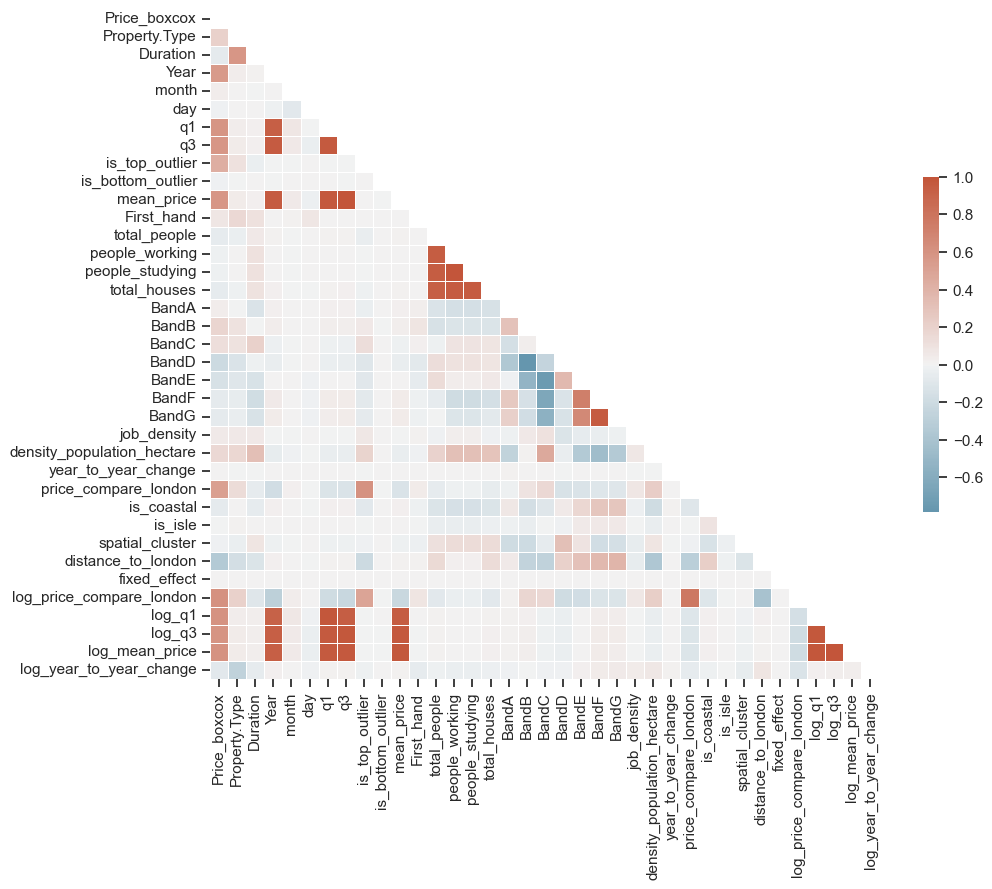

In [126]:
def show_correlation(df):
    # Compute the correlation matrix
    corr = df.select_dtypes(include='number').corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.tight_layout()
    plt.show()

    return corr

variables = [v for v in train_df.columns if v not in ("Price_boxcox", "org_price", "Price", "org_mean_price")]
corr = show_correlation(train_df.loc[:, ["Price_boxcox"]+variables])

# Save results
with open('../output/correlations.pkl', 'wb') as f:
            pickle.dump(corr, f)

# del corr

In [124]:
temp

,index,0
0,Property_Type:District[aberconwy],3.248950e-01
1,Property_Type:District[adur],-2.596234e-01
2,Property_Type:District[allerdale],1.710326e-01
3,Property_Type:District[alnwick],5.752596e-01
4,Property_Type:District[alyn and deeside],-2.537373e-01
...,...,...
14286,distance_to_london:District[wycombe],1.246658e-01
14287,distance_to_london:District[wyre],-3.349584e-01
14288,distance_to_london:District[wyre forest],-3.093144e-01
14289,distance_to_london:District[ynys mon-isle of a...,9.302968e-03


<Axes: >

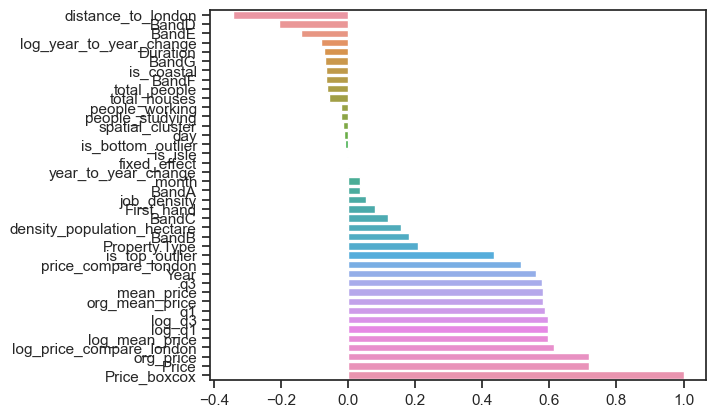

In [125]:
fig, ax = plt.subplots(1)
temp = corr["Price_boxcox"].sort_values()
sns.barplot(x=temp.values, y=temp.index)

Eliminamos las que tienen correlación extremadamente alta con otras variables explicativas:

In [ ]:
if "BandG" in train_df.columns:
    train_df.drop(columns=["BandG", "total_houses", 
                           "people_studying", "people_working"], 
                           axis=1, inplace=True)
    test_df.drop(columns=["BandG", "total_houses", 
                            "people_studying", "people_working"], 
                            axis=1, inplace=True)

## Feature Importance

In [ ]:
# Save results
with open('../output/train_df.pkl', 'wb') as f:
            pickle.dump(train_df, f)
            
with open('../output/test_df.pkl', 'wb') as f:
            pickle.dump(test_df, f)


In [ ]:
# Load results
with open('../output/train_df.pkl', 'rb') as f:
            train_df = pickle.load(f)
            
with open('../output/test_df.pkl', 'rb') as f:
            test_df = pickle.load(f)

In [ ]:
explainatory_names = [v for v in train_df.select_dtypes("number").columns
                      if v not in ["Price", "Price_boxcox", "date2", "org_price"]]
target_name = "Price_boxcox"

In [ ]:
def get_feature_importance(df, ex_names=explainatory_names, 
                           target_name=target_name,
                           max_depth=3):
    # Random Forest Model
    regr = RandomForestRegressor(random_state=0, 
                                oob_score=True, 
                                max_depth=max_depth)
    regr.fit(X=df.loc[:, explainatory_names].values, 
            y=df[target_name].values)

    # Feature Importance
    feature_importance = regr.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(pos, feature_importance[sorted_idx], align='center')
    ax.set_yticks(pos)
    ax.set_yticklabels(np.array(explainatory_names)[sorted_idx])
    ax.set_xlabel('Feature Importance')
    ax.set_title('Random Forest Feature Importances')
    plt.tight_layout()
    plt.show()

    return regr

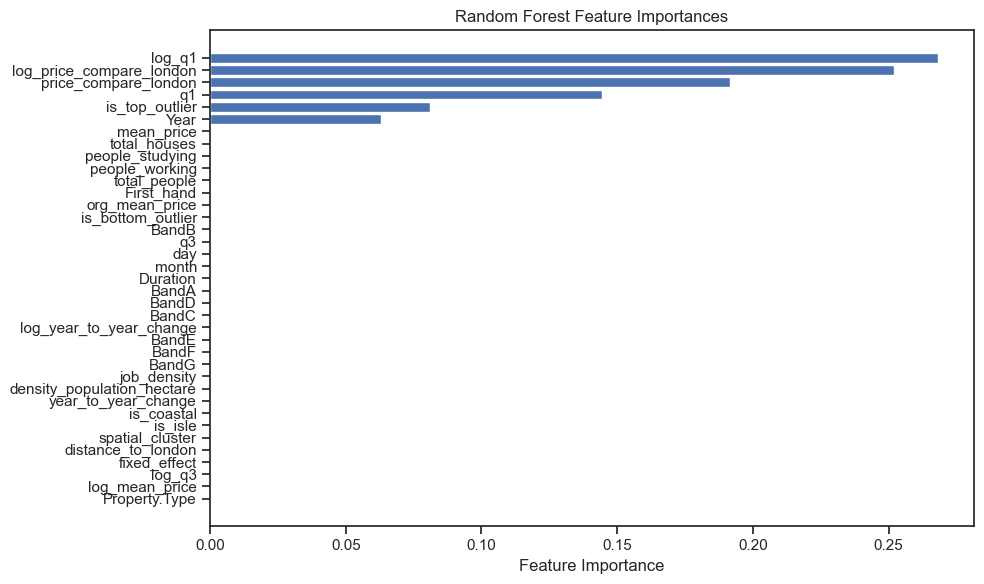

In [ ]:
regr = get_feature_importance(train_df)

In [ ]:
# explainatory_names[regr.feature_importances_>0]
[n for n,b in zip(explainatory_names, (regr.feature_importances_>0)) if b]

['Year',
 'q1',
 'is_top_outlier',
 'price_compare_london',
 'log_price_compare_london',
 'log_q1']

# Modelos de prueba

## Random Forest

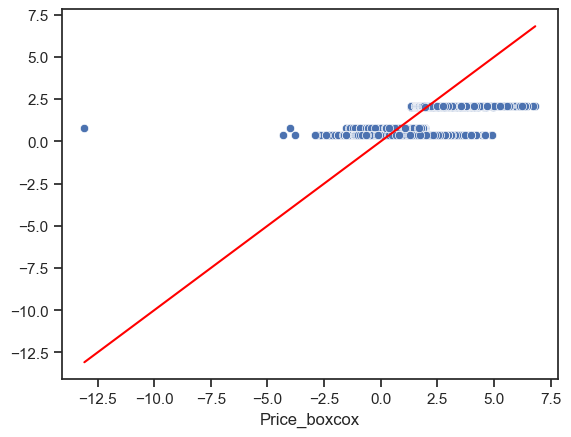

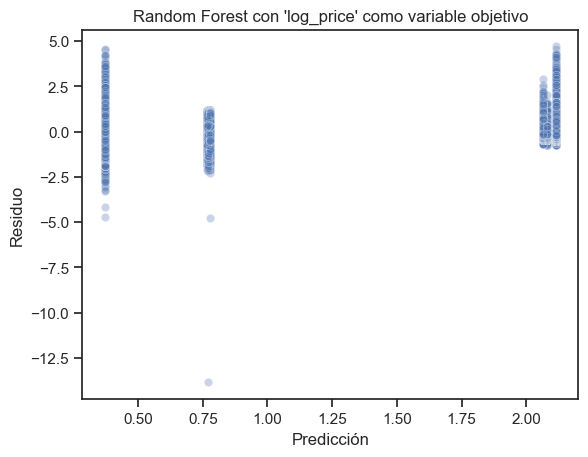

In [ ]:
pred = regr.predict(test_df.loc[:, explainatory_names].\
                    fillna(-1).values)

sns.scatterplot(x=test_df["Price_boxcox"], y=pred)
sns.lineplot(x=[min(test_df["Price_boxcox"]),max(test_df["Price_boxcox"])],
             y=[min(test_df["Price_boxcox"]),max(test_df["Price_boxcox"])],
             color="red")
# plt.axes((min(y_test), min(pred), max(y_test), max(pred)))
plt.show()

resi = test_df["Price_boxcox"] - pred
sns.scatterplot(x=pred, y=resi, alpha=0.3)
plt.xlabel("Predicción")
plt.ylabel("Residuo")
plt.title("Random Forest con 'log_price' como variable objetivo")

del pred
plt.show()


In [ ]:
regr.score(X=test_df.loc[:, explainatory_names].fillna(-1).values,
           y=test_df["Price_boxcox"])

0.36611616802643276

Text(0.5, 1.0, "Random Forest con 'log_price' como variable objetivo")

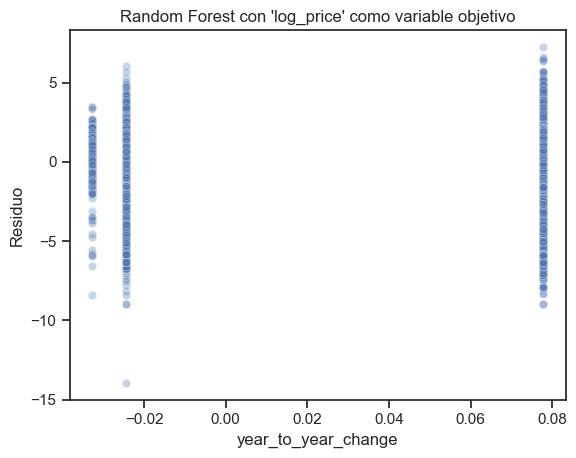

In [ ]:
x_name = "year_to_year_change"
sns.scatterplot(x=test_df[x_name], y=resi, alpha=0.3)
plt.xlabel(x_name)
plt.ylabel("Residuo")
plt.title("Random Forest con 'log_price' como variable objetivo")

# Forma sugiere poly(.) o 1/x

Text(0.5, 1.0, "Random Forest con 'log_price' como variable objetivo")

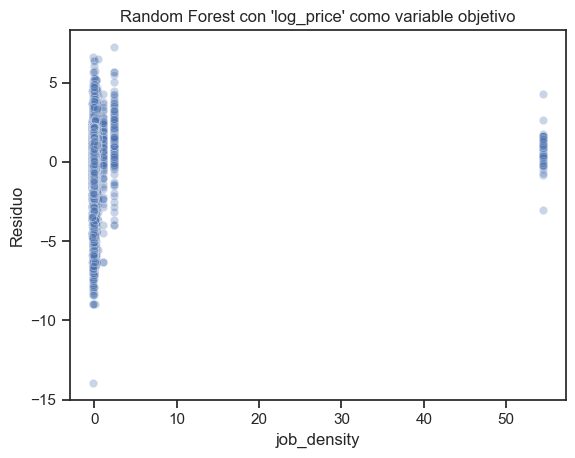

In [ ]:
x_name = "job_density"
sns.scatterplot(x=test_df[x_name], y=resi, alpha=0.3)
plt.xlabel(x_name)
plt.ylabel("Residuo")
plt.title("Random Forest con 'log_price' como variable objetivo")

# Forma sugiere log(.)

Text(0.5, 1.0, "Random Forest con 'log_price' como variable objetivo")

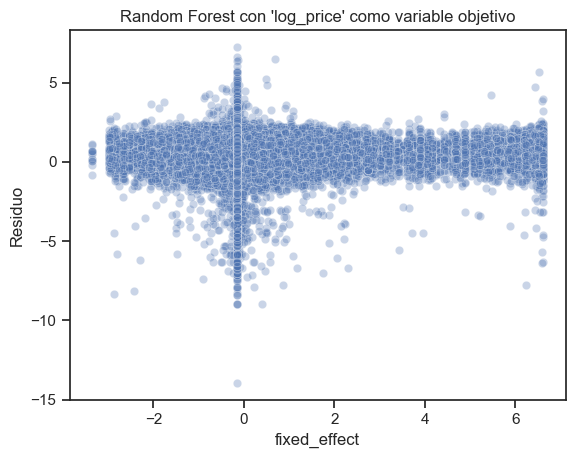

In [ ]:
x_name = "fixed_effect"
sns.scatterplot(x=test_df[x_name], y=resi, alpha=0.3)
plt.xlabel(x_name)
plt.ylabel("Residuo")
plt.title("Random Forest con 'log_price' como variable objetivo")

# Corregir datos faltantes

Text(0.5, 1.0, "Random Forest con 'log_price' como variable objetivo")

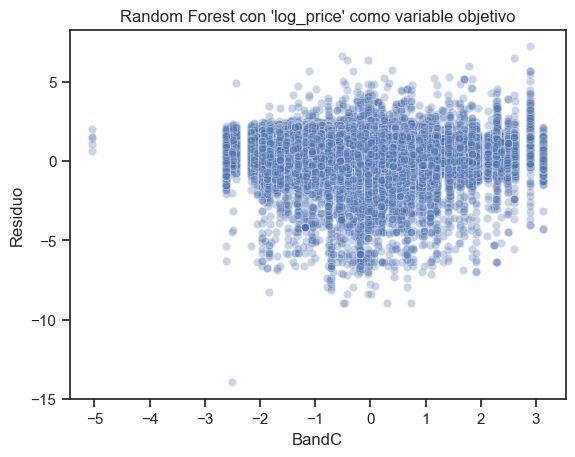

In [ ]:
x_name = "BandC"
sns.scatterplot(x=test_df[x_name], y=resi, alpha=0.3)
plt.xlabel(x_name)
plt.ylabel("Residuo")
plt.title("Random Forest con 'log_price' como variable objetivo")

# Corregir datos faltantes

Text(0.5, 1.0, "Random Forest con 'log_price' como variable objetivo")

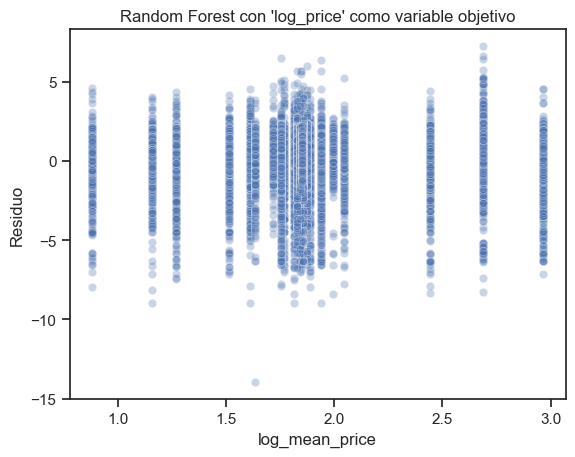

In [ ]:
x_name = "log_mean_price"
sns.scatterplot(x=test_df[x_name], y=resi, alpha=0.3)
plt.xlabel(x_name)
plt.ylabel("Residuo")
plt.title("Random Forest con 'log_price' como variable objetivo")

# Corregir datos faltantes

### Random Forest con variables transformadas

In [ ]:
train_df

,Price,Property.Type,Duration,Town.City,District,County,Year,month,day,q1,...,year_to_year_change,price_compare_london,is_coastal,is_isle,spatial_cluster,fixed_effect,log_price_compare_london,log_q1,log_q3,log_year_to_year_change
0,0.132888,1.483691,1.796628,london,merton,greater london,-1.604038,-1.743947,-1.778077,-0.835481,...,0.002860,4.872326,-0.603302,-0.057107,1.687433,-0.137492,2.017956,-0.917677,-0.914033,-1.508812
1,-0.182963,-0.294065,-0.556482,horsham,horsham,west sussex,-1.604038,-1.743947,-1.778077,-0.809697,...,0.002860,0.597630,-0.603302,-0.057107,-0.828114,-0.117002,0.924411,-0.861986,-0.658675,-1.508812
2,-0.231821,-1.182943,-0.556482,dewsbury,kirklees,west yorkshire,-1.604038,-1.743947,-1.778077,-1.131990,...,0.002860,-0.063597,-0.603302,-0.057107,0.848917,0.156319,0.395625,-1.756960,-1.891702,-1.508812
3,-0.223563,-0.294065,-0.556482,gloucester,gloucester,gloucestershire,-1.604038,-1.743947,-1.778077,-1.054640,...,0.002860,0.048160,-0.603302,-0.057107,-0.828114,-0.164172,0.515104,-1.491843,-1.778997,-1.508812
4,-0.107957,0.594813,-0.556482,macclesfield,macclesfield,cheshire,-1.604038,-1.743947,-1.778077,-0.925723,...,0.002860,1.612754,-0.603302,-0.057107,-0.828114,-0.174553,1.356870,-1.129593,-0.863031,-1.508812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2601993,-0.272345,2.372569,-0.556482,liverpool,sefton,merseyside,1.734141,1.547704,1.541218,-0.229570,...,-0.012017,-0.707746,1.657544,-0.057107,-0.828114,-0.170499,-2.949691,0.049414,0.479672,0.245374
2601994,-0.074239,-1.182943,-0.556482,penarth,the vale of glamorgan,the vale of glamorgan,1.734141,1.547704,1.541218,0.346851,...,-0.039080,-0.506509,-0.603302,-0.057107,-0.688362,-0.170499,-0.463376,0.621595,0.938777,0.894953
2601995,-0.204295,2.372569,1.796628,harrogate,harrogate,north yorkshire,1.734141,1.547704,1.541218,1.248143,...,-0.006641,-0.638621,-0.603302,-0.057107,-0.828114,-0.170443,-1.218471,1.236572,1.412785,-0.023517
2601996,5.774994,2.372569,-0.556482,bristol,south gloucestershire,south gloucestershire,1.734141,1.547704,1.541218,1.375449,...,-0.303256,5.435172,1.657544,-0.057107,0.639288,-0.424247,2.090426,1.306999,1.134850,2.183281


In [ ]:
def new_variables(df):
    df["year_to_year_change_2"] = np.square(df["year_to_year_change"])
    df["year_to_year_change_inv"] = 1/(df["year_to_year_change"] + 0.001)
    df["job_density_inv"] = 1/(df["job_density"] + 0.001)

new_variables(train_df)
new_variables(test_df)

numeric_columns = train_df.select_dtypes(include=['number']).columns
train_df[numeric_columns] = train_df[numeric_columns].fillna(train_df[numeric_columns].mean())
test_df[numeric_columns] = test_df[numeric_columns].fillna(test_df[numeric_columns].mean())
train_df.head()

,Price,Property.Type,Duration,Town.City,District,County,Year,month,day,q1,...,is_isle,spatial_cluster,fixed_effect,log_price_compare_london,log_q1,log_q3,log_year_to_year_change,year_to_year_change_2,year_to_year_change_inv,job_density_inv
0,0.132888,1.483691,1.796628,london,merton,greater london,-1.604038,-1.743947,-1.778077,-0.835481,...,-0.057107,1.687433,-0.137492,2.017956,-0.917677,-0.914033,-1.508812,0.000008,259.035692,-6.821541
1,-0.182963,-0.294065,-0.556482,horsham,horsham,west sussex,-1.604038,-1.743947,-1.778077,-0.809697,...,-0.057107,-0.828114,-0.117002,0.924411,-0.861986,-0.658675,-1.508812,0.000008,259.035692,-25.983495
2,-0.231821,-1.182943,-0.556482,dewsbury,kirklees,west yorkshire,-1.604038,-1.743947,-1.778077,-1.131990,...,-0.057107,0.848917,0.156319,0.395625,-1.756960,-1.891702,-1.508812,0.000008,259.035692,-7.936360
3,-0.223563,-0.294065,-0.556482,gloucester,gloucester,gloucestershire,-1.604038,-1.743947,-1.778077,-1.054640,...,-0.057107,-0.828114,-0.164172,0.515104,-1.491843,-1.778997,-1.508812,0.000008,259.035692,-43.399196
4,-0.107957,0.594813,-0.556482,macclesfield,macclesfield,cheshire,-1.604038,-1.743947,-1.778077,-0.925723,...,-0.057107,-0.828114,-0.174553,1.356870,-1.129593,-0.863031,-1.508812,0.000008,259.035692,-1.159799


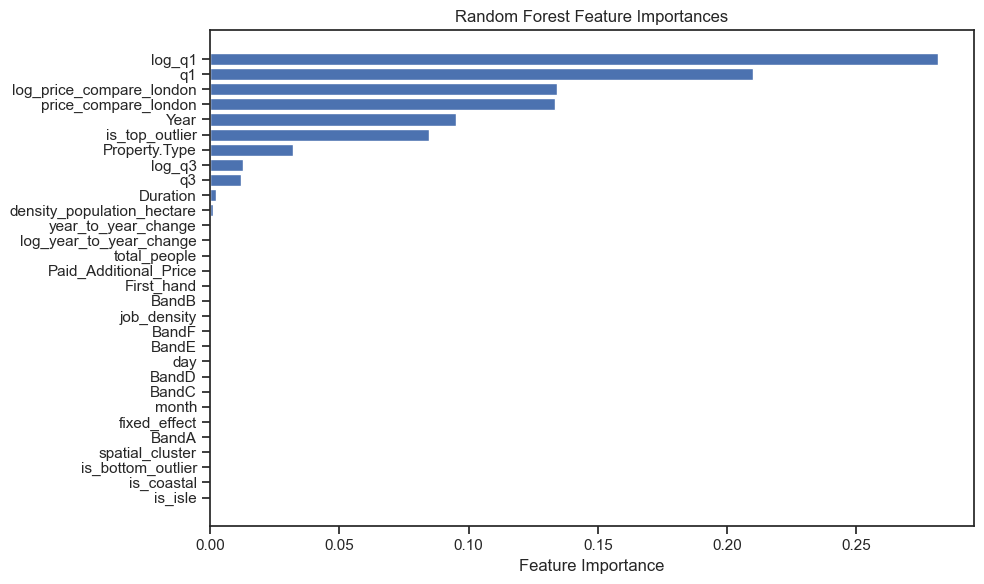

In [ ]:
regr = get_feature_importance(train_df, max_depth=10)

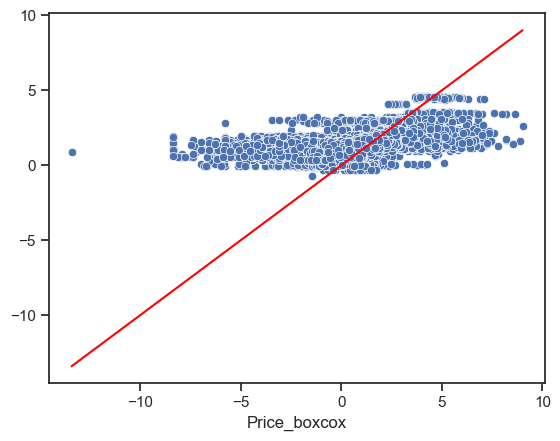

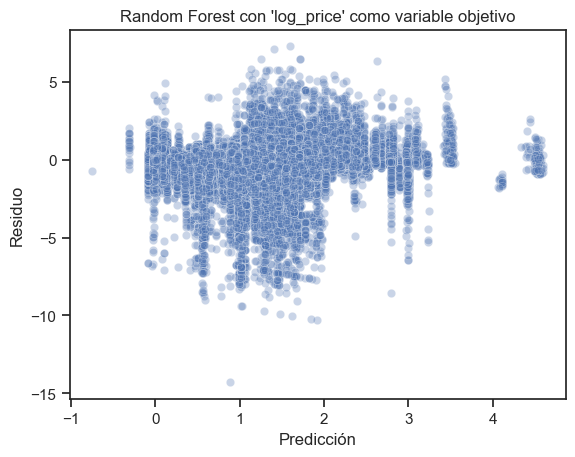

In [ ]:
pred = regr.predict(test_df.loc[:, explainatory_names].\
                    fillna(-1).values)

sns.scatterplot(x=test_df["Price_boxcox"], y=pred)
sns.lineplot(x=[min(test_df["Price_boxcox"]),max(test_df["Price_boxcox"])],
             y=[min(test_df["Price_boxcox"]),max(test_df["Price_boxcox"])],
             color="red")
# plt.axes((min(y_test), min(pred), max(y_test), max(pred)))
plt.show()

resi = test_df["Price_boxcox"] - pred
sns.scatterplot(x=pred, y=resi, alpha=0.3)
plt.xlabel("Predicción")
plt.ylabel("Residuo")
plt.title("Random Forest con 'log_price' como variable objetivo")

del pred
plt.show()


In [ ]:
regr.score(X=test_df.loc[:, explainatory_names].fillna(-1).values,
           y=test_df["Price_boxcox"])

0.12368490992428294

Text(0.5, 1.0, "Random Forest con 'log_price' como variable objetivo")

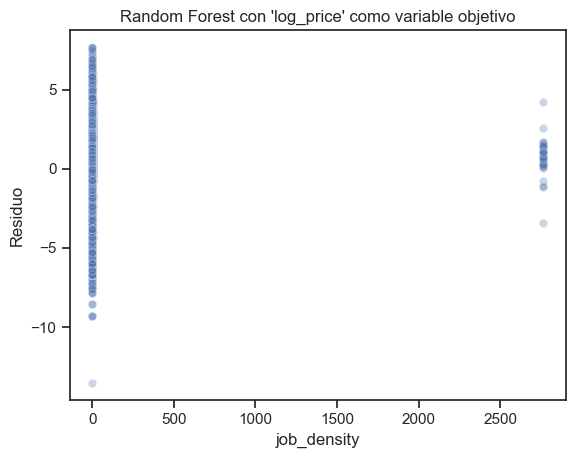

In [ ]:
x_name = "job_density"
sns.scatterplot(x=np.square(test_df[x_name]), y=resi, alpha=0.3)
plt.xlabel(x_name)
plt.ylabel("Residuo")
plt.title("Random Forest con 'log_price' como variable objetivo")

# Forma sugiere log(.)